# Samples analysis
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hsimonfroy/benchmark-field-level/blob/main/examples/sample_analysis.ipynb)

Analyse cosmological model posterior samples.

In [2]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.7' # NOTE: jax preallocates GPU (default 75%)
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from jax import numpy as jnp, random as jr, config as jconfig, devices as jdevices, jit, vmap, grad, debug, tree
jconfig.update("jax_enable_x64", True)
print(jdevices())

from montecosmo.model import FieldLevelModel, default_config
from montecosmo.utils import pdump, pload, Path
from getdist import plots

%matplotlib inline
%load_ext autoreload
%autoreload 2
!hostname

save_dir = Path("/feynman/home/dphp/hs276503/scratch/png/kaiser_test19")
# save_dir = Path("/pscratch/sd/h/hsimfroy/png/lpt_64_fnl_0")
save_path = save_dir / "test"
save_dir.mkdir(parents=True, exist_ok=True)

[cuda(id=0)]
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
feynmangpu04.cluster.local


## Example 1: assess MCMC convergence

In [4]:
from montecosmo.chains import Chains
from montecosmo.plot import plot_pow, plot_trans, plot_coh, plot_powtranscoh, theme, SetDark2
theme(usetex=False, font_size=12)

model = FieldLevelModel.load(save_dir / "model.yaml")
truth = dict(jnp.load(save_dir / 'truth.npz'))
mesh_true = jnp.fft.irfftn(truth['init_mesh'])
kpow_true = model.spectrum(mesh_true)
delta_obs = model.count2delta(truth['obs'])
kptc_obs = model.powtranscoh(mesh_true, delta_obs)

obs = ['obs','Omega_m','sigma8','b1','b2','bs2','bn2','bnp','fNL','ngbar','init_mesh']
# obs = ['obs','Omega_b','Omega_c','sigma8','b1','b2','bs2','bn2','bnp','fNL','ngbar','init_mesh']
obs = {k: truth[k] for k in obs}
model.condition(obs, from_base=True)

transforms = [
            #   lambda x: x[:3],
              partial(Chains.thin, thinning=1),                     # thin the chains
              model.reparam_chains,                                 # reparametrize sample variables into base variables
            #   partial(model.powtranscoh_chains, mesh0=mesh_true),   # compute mesh statistics
              partial(Chains.choice, n=10, names=['init','init_']), # subsample mesh 
              Chains.prune,
              ]
chains = model.load_runs(save_path, 1, 20, transforms=transforms, batch_ndim=2)
names = ['cosmo','bias','ap','syst','init']
# names = ['cosmo_','bias_','ap_','syst_','init_']
chains.shape

Loading: test, from run 1 to run 20 (included)
File /feynman/home/dphp/hs276503/scratch/png/kaiser_test19/test_17.npz does not exist, stopping at run 16


{'Omega_m': (4, 2048),
 'alpha_iso': (4, 2048),
 'init_mesh': (4, 2048, 10),
 'logdensity': (4, 2048),
 'mse_per_dim': (4, 2048),
 'n_evals': (4, 2048),
 'ngbarr_': (4, 2048, 17),
 'sigma8': (4, 2048)}

### Inspecting chains
We look for mixed chains (no visible trends), `n_eff`>500, `r_hat`<1.01

ss:  30.25775864547915
L:  6051.55172909583
inv_mm: {'Omega_m_': Array(0.39312372, dtype=float64), 'alpha_iso_': Array(0.00123444, dtype=float64), 'init_mesh_': Array([[[ 0.81469739,  4.35104607,  6.51357604, ...,  6.69036711,
          7.12310419,  9.76620186],
        [ 3.17728799,  4.7328482 ,  6.32299865, ...,  9.85189605,
          4.87997274,  4.6744975 ],
        [ 2.60690799,  6.15295795,  3.63964977, ...,  4.51021137,
          5.9534855 ,  6.52323546],
        ...,
        [ 4.31432115,  4.18996155,  6.37394863, ...,  5.86839946,
          6.18588018,  5.47968885],
        [ 6.11004666,  4.48428347,  3.75394792, ...,  5.90523525,
          7.73430446,  7.93050643],
        [ 7.3836877 ,  4.54217767,  6.24145933, ..., 11.39899671,
          7.31208056,  3.36214034]],

       [[ 2.12825196,  5.26883252,  8.37089833, ...,  6.49385461,
         15.2815424 ,  4.85375288],
        [ 3.94792929,  4.16708508,  3.5176064 , ...,  8.95902414,
          6.7208789 ,  7.28183989],
        

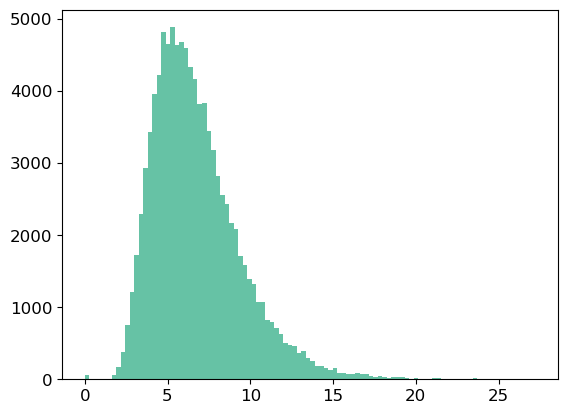

In [5]:
config = pload(save_path+"_conf.p")
state = pload(save_path+"_last_state.p")

print("ss: ", config.step_size[0])
print("L: ", config.L[0])
from jax.flatten_util import ravel_pytree
flat, unrav_fn = ravel_pytree(tree.map(lambda x:x[0], state.position))
print("inv_mm:", unrav_fn(config.inverse_mass_matrix[0]))

# plt.hist(chains['init_mesh_'].std((0,1)), bins=50);
plt.hist(np.random.choice(config.inverse_mass_matrix[0], 100_000), bins=100);

[7.75305559 4.79064446 3.44575676 2.71015412 2.42538416 2.23480871
 2.33349251 2.3966478  2.41953128 2.50383915 2.53880137 2.65089917
 2.593645   2.62532214 2.69588859 3.76314708 9.15401482]


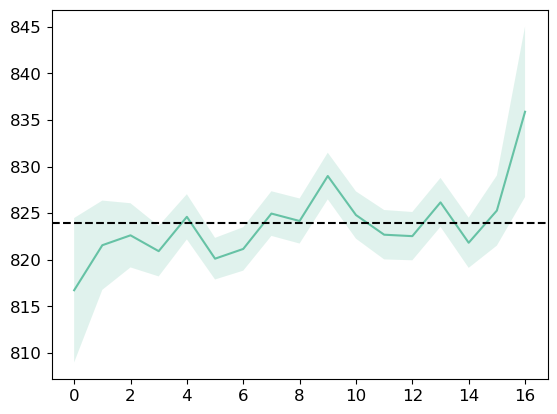

In [6]:
rcounts = (1e-5 * chains['ngbarr_'] + 1e-3) * model.cell_length**3
rcountm, rcountstd = rcounts.mean((0,1)), rcounts.std((0,1))
plt.plot(rcountm)
plt.fill_between(np.arange(len(rcountm)), rcountm-rcountstd, rcountm+rcountstd, alpha=0.2)
plt.axhline(model.count_fid, color='k', linestyle='--', label="mean")
print(rcountstd)

[6.19968514 3.57120123 2.77866627 2.15417031 1.92322518 1.75863958
 1.7877467  1.88744139 1.86718496 1.86297471 1.99619109 1.95529042
 1.95614991 1.9623089  2.09788241 2.75351574 5.35074541]


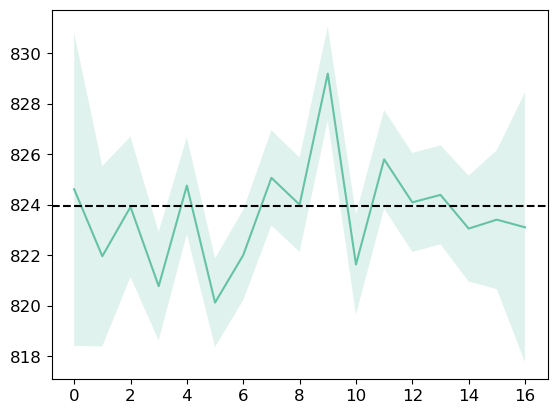

In [ ]:
rcounts = (1e-5 * chains['ngbarr_'] + 1e-3) * model.cell_length**3
rcountm, rcountstd = rcounts.mean((0,1)), rcounts.std((0,1))
plt.plot(rcountm)
plt.fill_between(np.arange(len(rcountm)), rcountm-rcountstd, rcountm+rcountstd, alpha=0.2)
plt.axhline(model.count_fid, color='k', linestyle='--', label="mean")
print(rcountstd)

[7.17295004 4.26859921 3.21533018 2.50701142 2.19543639 2.11923043
 2.08914462 2.17553552 2.2520099  2.30273263 2.27516575 2.30668307
 2.36441094 2.35557845 2.49428046 3.14082734 6.59337401]


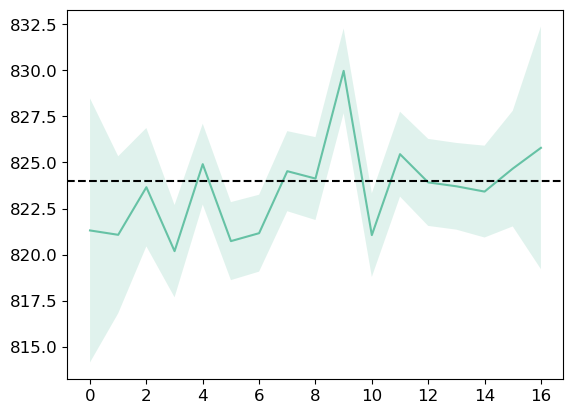

In [ ]:
rcounts = (1e-5 * chains['ngbarr_'] + 1e-3) * model.cell_length**3
rcountm, rcountstd = rcounts.mean((0,1)), rcounts.std((0,1))
plt.plot(rcountm)
plt.fill_between(np.arange(len(rcountm)), rcountm-rcountstd, rcountm+rcountstd, alpha=0.2)
plt.axhline(model.count_fid, color='k', linestyle='--', label="mean")
print(rcountstd)


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
       sigma8      0.85      0.04      0.85      0.79      0.92   4373.71      1.00
   logdensity -183813.21    153.96 -183811.78 -184065.11 -183560.27   3405.46      1.00
   ngbarr_[0]     -0.88      0.94     -0.89     -2.48      0.59  47989.98      1.00
   ngbarr_[1]     -0.29      0.58     -0.30     -1.23      0.68  35685.90      1.00
   ngbarr_[2]     -0.16      0.42     -0.17     -0.84      0.52  26051.84      1.00
   ngbarr_[3]     -0.37      0.33     -0.37     -0.90      0.18  29133.21      1.00
   ngbarr_[4]      0.08      0.29      0.07     -0.42      0.54  23989.78      1.00
   ngbarr_[5]     -0.47      0.27     -0.47     -0.92     -0.03  24927.94      1.00
   ngbarr_[6]     -0.34      0.28     -0.34     -0.81      0.12  23206.37      1.00
   ngbarr_[7]      0.12      0.29      0.12     -0.38      0.58  63245.34      1.00
   ngbarr_[8]      0.02      0.29      0.02     -0.46      0.51  35372.

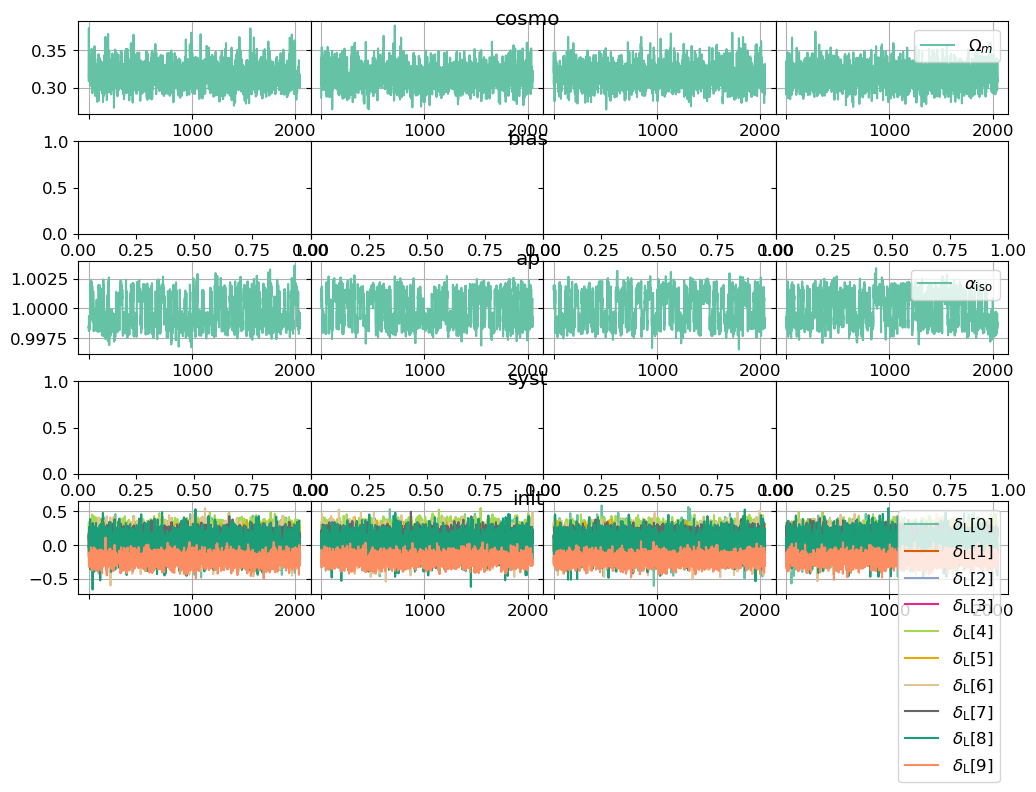

In [7]:
plt.figure(figsize=(12,6))
chains[['*~kptc','~sigma8']].prune().flatten().plot(names)
chains[['*~kptc']].print_summary()

Removed no burn in


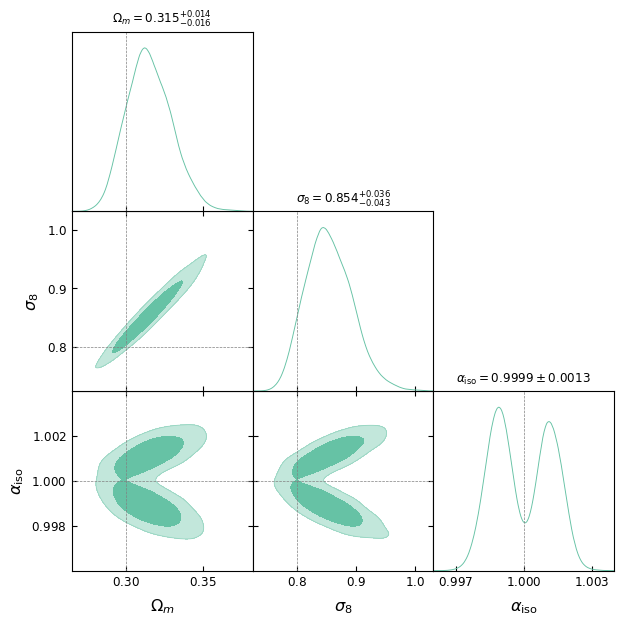

In [8]:
gdsamp = chains[np.array([0,2,4,5]),10:][names[:-1]].to_getdist()
# Kaiser, invAP, regular, 0.5 oversampling
gdplt = plots.get_subplot_plotter(width_inch=7)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,
                contour_colors=[SetDark2(0)],)

Removed no burn in


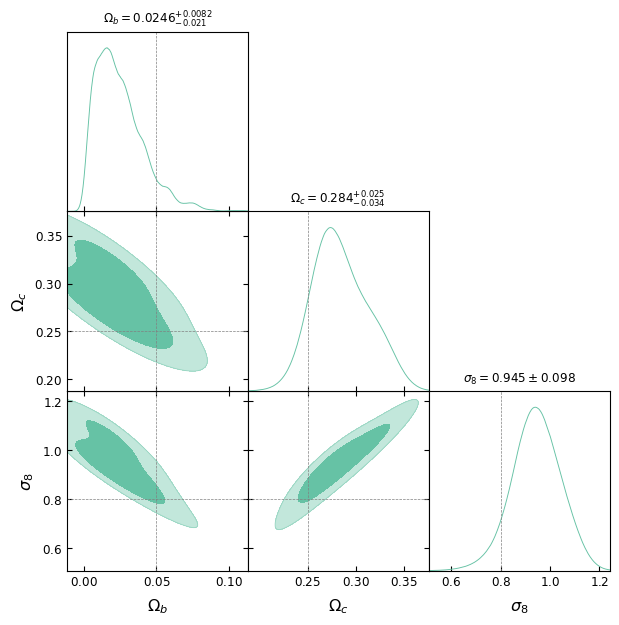

In [ ]:
gdsamp = chains[np.array([0,2,4,5]),10:][names[:-1]].to_getdist()
# Kaiser, AP, Sobol, 0.25 oversampling
gdplt = plots.get_subplot_plotter(width_inch=7)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,
                contour_colors=[SetDark2(0)],)

Removed no burn in


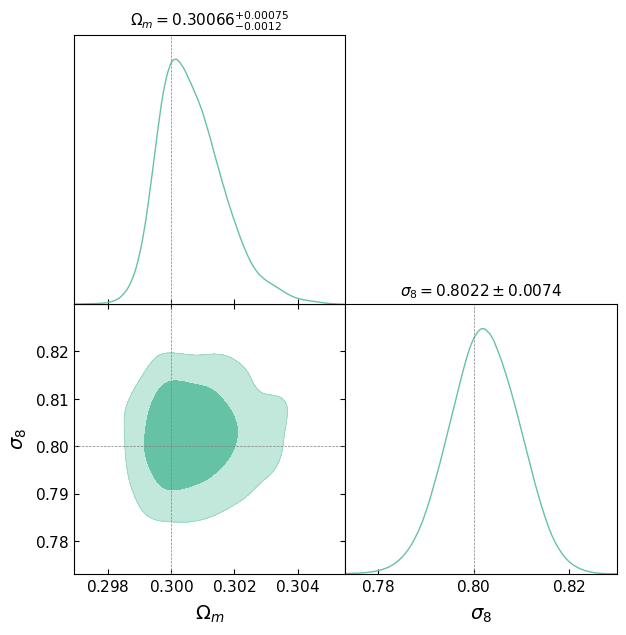

In [ ]:
gdsamp = chains[np.array([0,2,4,5]),10:][names[:-1]].to_getdist()
# Kaiser, AP, Sobol, 0.25 oversampling
gdplt = plots.get_subplot_plotter(width_inch=7)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,
                contour_colors=[SetDark2(0)],)

Removed no burn in


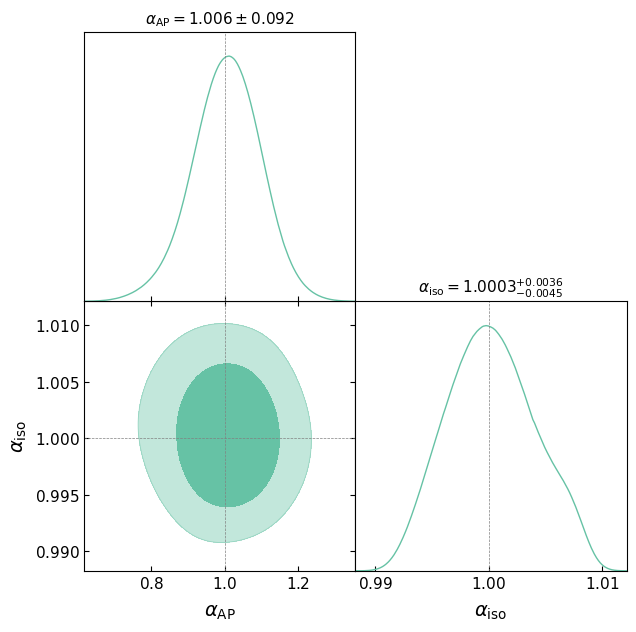

In [ ]:
gdsamp = chains[np.array([0,2,4,5]),10:][names[:-1]].to_getdist()
# Regular, AP param, Sobol, 0.25 oversampling
gdplt = plots.get_subplot_plotter(width_inch=7)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,
                contour_colors=[SetDark2(0)],)

Removed no burn in


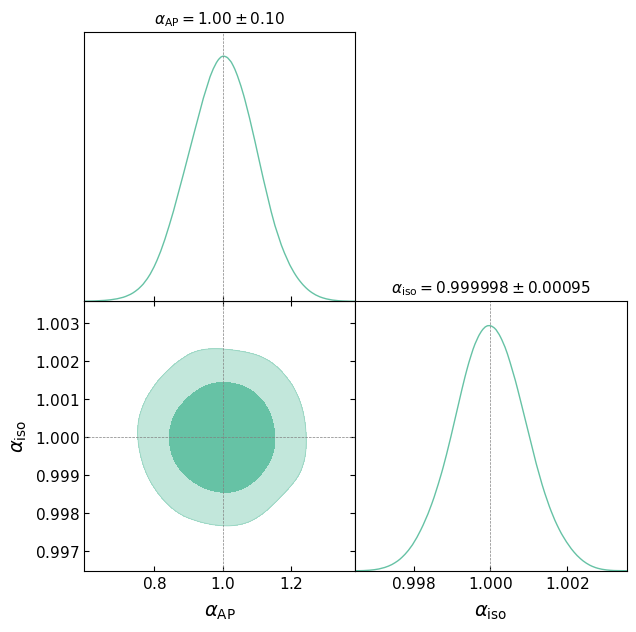

In [ ]:
gdsamp = chains[np.array([0,2,4,5]),10:][names[:-1]].to_getdist()
# Regular, AP param
gdplt = plots.get_subplot_plotter(width_inch=7)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,
                contour_colors=[SetDark2(0)],)

Removed no burn in


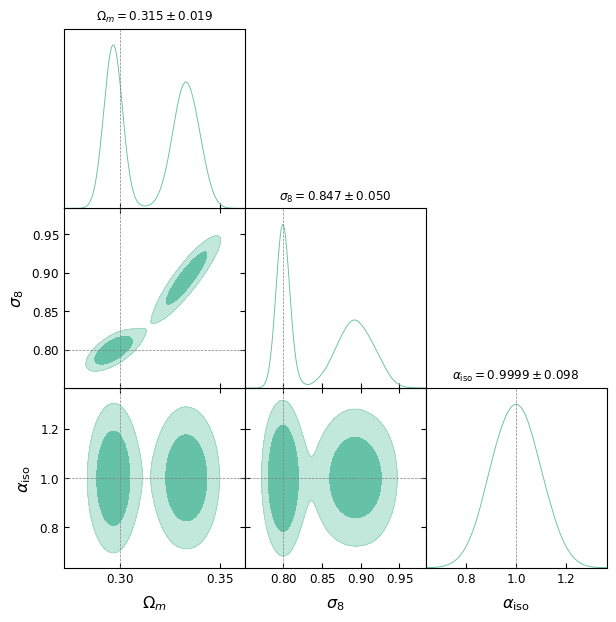

In [ ]:
gdsamp = chains[np.array([0,2,4,5]),10:][names[:-1]].to_getdist()
# Kaiser LC, Curved, AP simplified, ngbar(r), CIC, 
gdplt = plots.get_subplot_plotter(width_inch=7)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,
                contour_colors=[SetDark2(0)],)

Removed no burn in


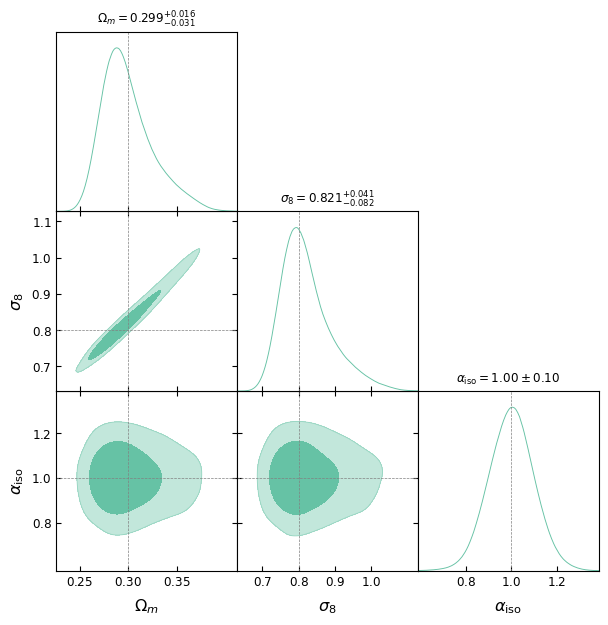

In [ ]:
gdsamp = chains[np.array([0,2,4,5]),10:][names[:-1]].to_getdist()
# Kaiser LC, Curved, AP simplified, ngbar(r), PCS
gdplt = plots.get_subplot_plotter(width_inch=7)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,
                contour_colors=[SetDark2(0)],)

Removed no burn in


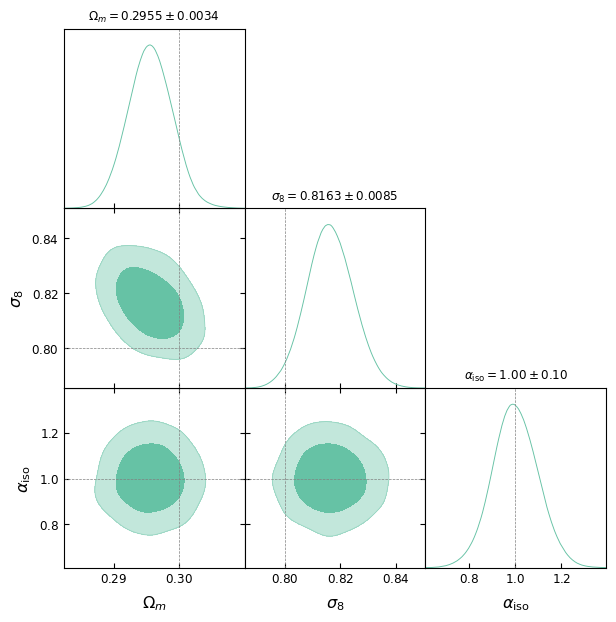

In [ ]:
gdsamp = chains[np.array([0,2,4,5]),10:][names[:-1]].to_getdist()
# Kaiser LC, Curved, AP simplified, ngbar(r)
gdplt = plots.get_subplot_plotter(width_inch=7)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,
                contour_colors=[SetDark2(0)],)

Removed no burn in


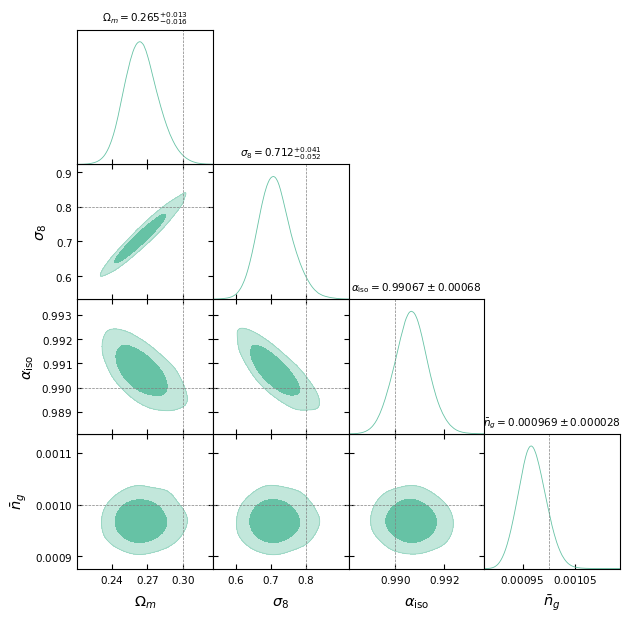

In [ ]:
gdsamp = chains[:,10:][names[:-1]].to_getdist()
# Kaiser LC, Curved, AP, ngbar(r)
gdplt = plots.get_subplot_plotter(width_inch=7)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,
                contour_colors=[SetDark2(0)],)

Removed no burn in


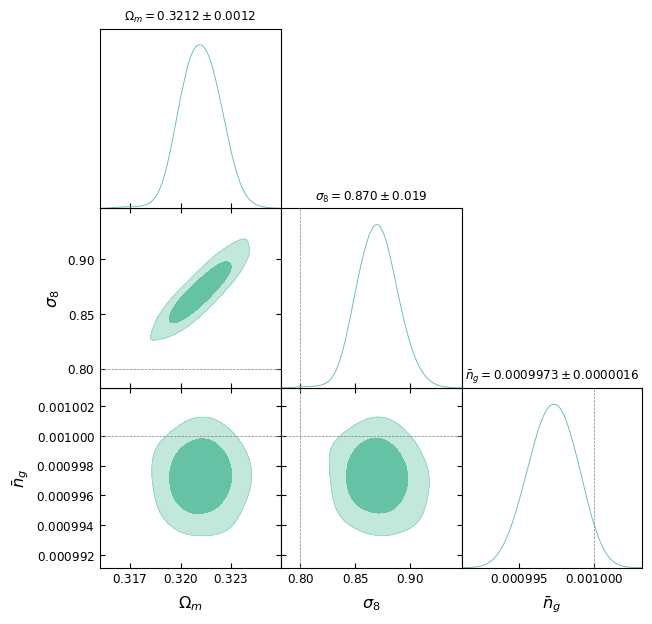

: 

In [ ]:
gdsamp = chains[1:,10:][names[:-1]].to_getdist()
# Kaiser LC, Curved, AP simplified
gdplt = plots.get_subplot_plotter(width_inch=7)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,
                contour_colors=[SetDark2(0)],)

Removed no burn in


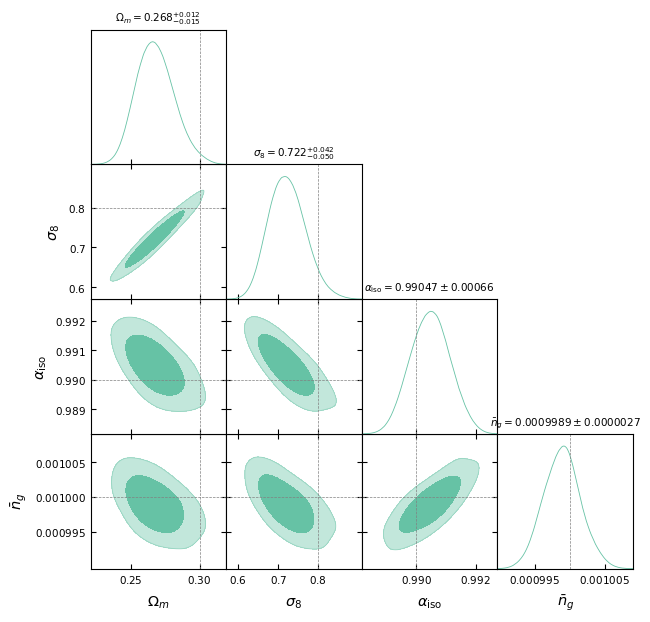

In [ ]:
gdsamp = chains[:2,0:][names[:-1]].to_getdist()
# Kaiser LC, Curved, AP no correct
gdplt = plots.get_subplot_plotter(width_inch=7)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,
                contour_colors=[SetDark2(0)],)

Removed no burn in


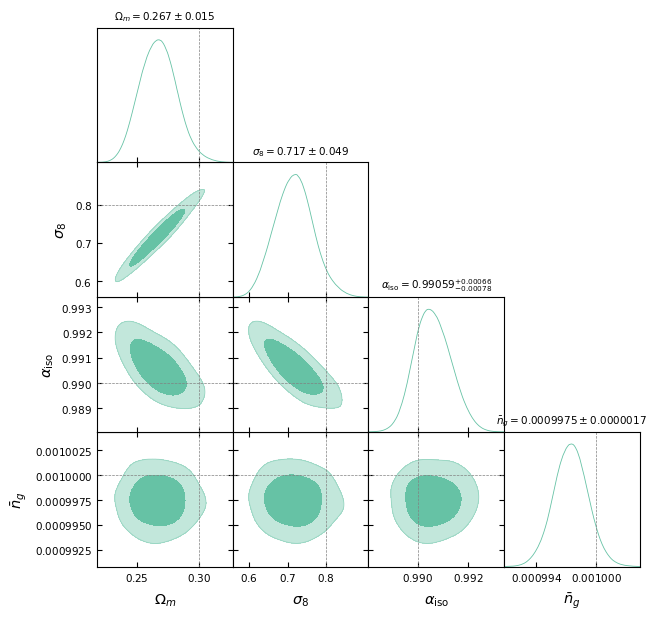

In [ ]:
gdsamp = chains[:2,0:][names[:-1]].to_getdist()
# Kaiser LC, Curved, AP
gdplt = plots.get_subplot_plotter(width_inch=7)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,
                contour_colors=[SetDark2(0)],)

Removed no burn in


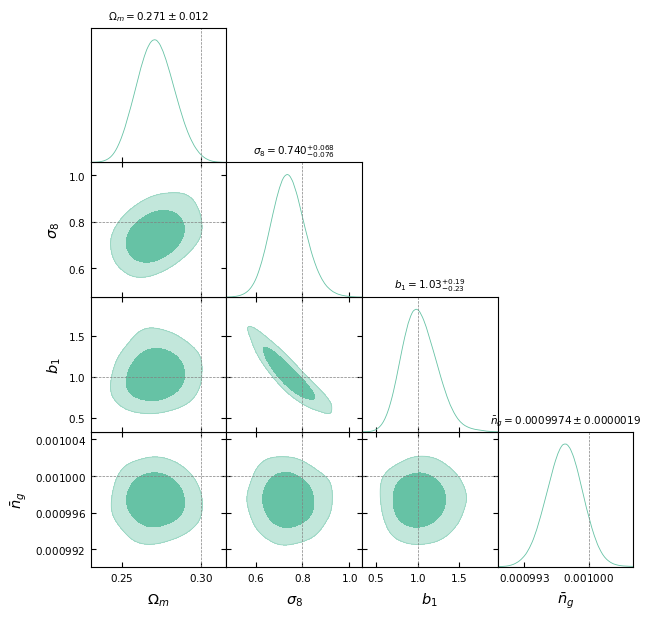

In [ ]:
gdsamp = chains[:2,0:][names[:-1]].to_getdist()
# Kaiser LC, Curved, AP
gdplt = plots.get_subplot_plotter(width_inch=7)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,
                contour_colors=[SetDark2(0)],)

Removed no burn in


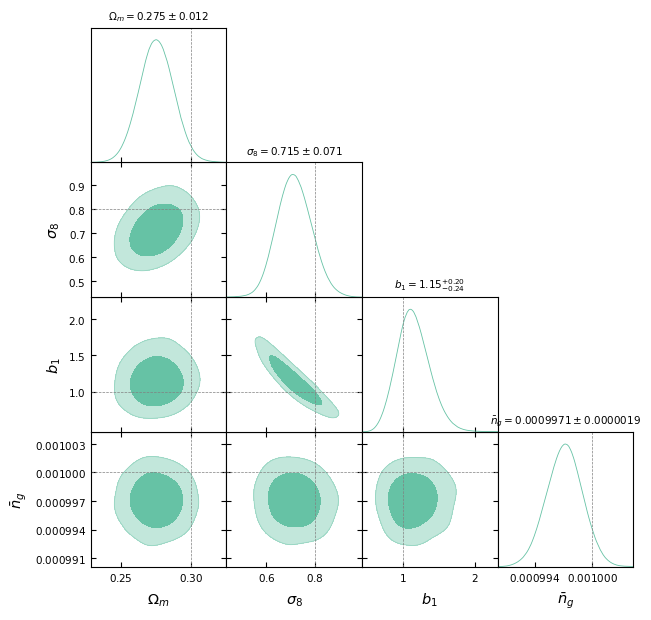

In [ ]:
gdsamp = chains[:2,0:][names[:-1]].to_getdist()
# Kaiser 0.5, Flat, noAP
gdplt = plots.get_subplot_plotter(width_inch=7)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,
                contour_colors=[SetDark2(0)],)

Removed no burn in


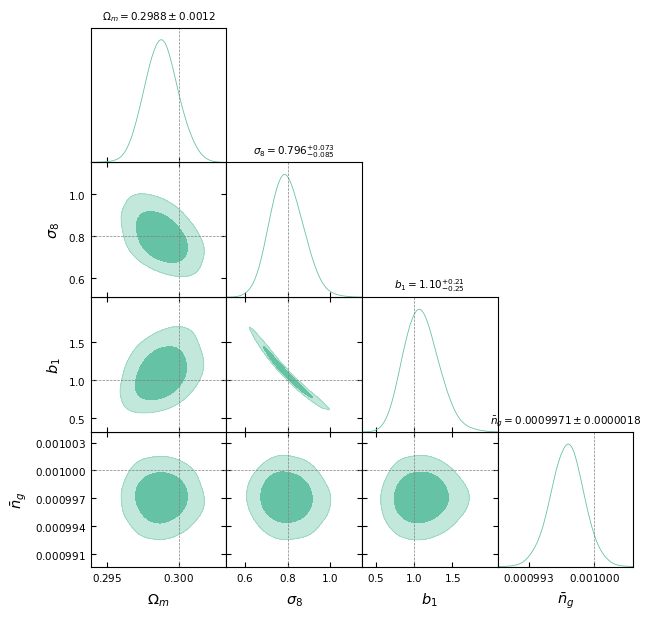

In [ ]:
gdsamp = chains[:2,0:][names[:-1]].to_getdist()
# Kaiser 0.5, Flat, AP
gdplt = plots.get_subplot_plotter(width_inch=7)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,
                contour_colors=[SetDark2(0)],)

Removed no burn in


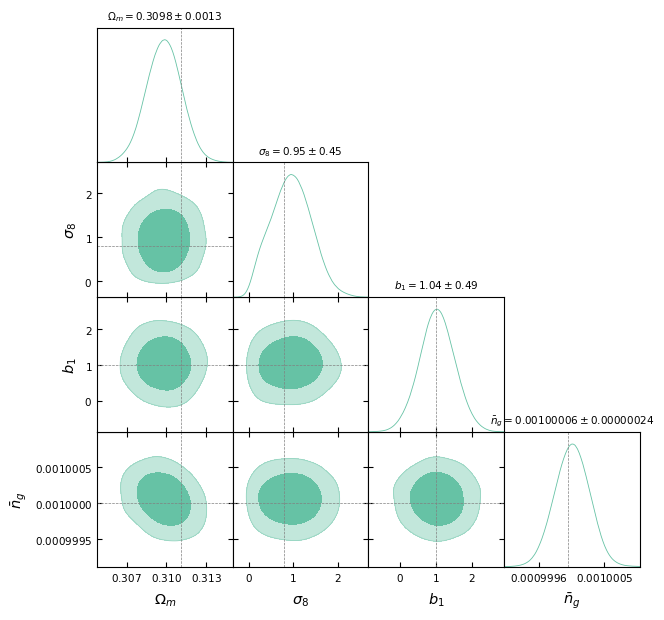

In [ ]:
gdsamp = chains[:,0:][names[:-1]].to_getdist()

gdplt = plots.get_subplot_plotter(width_inch=7)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,
                contour_colors=[SetDark2(0)],)

Removed no burn in


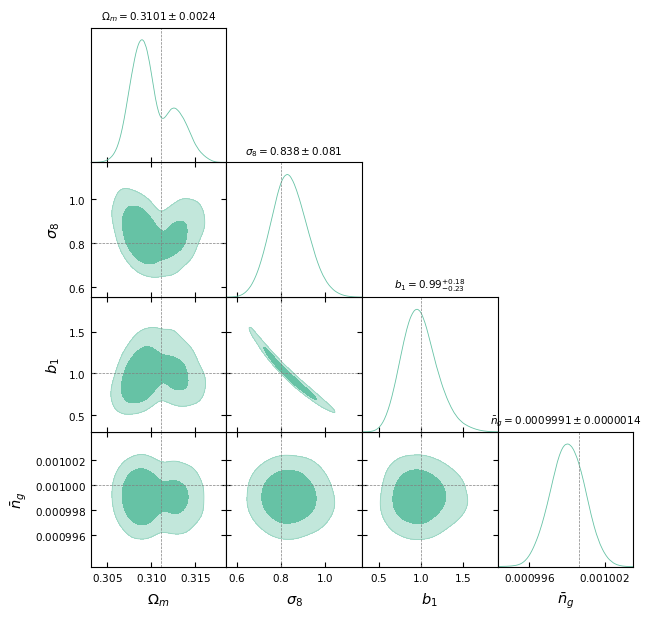

In [ ]:
gdsamp = chains[:,0:][names[:-1]].to_getdist()

gdplt = plots.get_subplot_plotter(width_inch=7)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,
                contour_colors=[SetDark2(0)],)

Removed no burn in


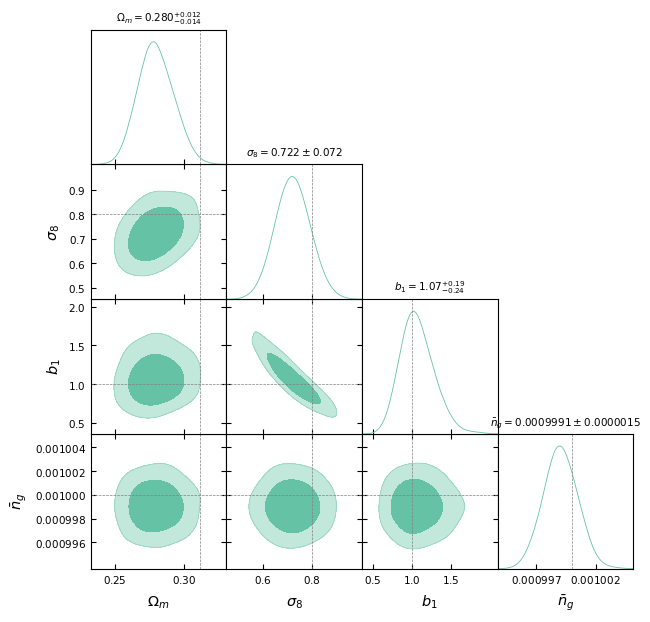

In [ ]:
gdsamp = chains[:,0:][names[:-1]].to_getdist()

gdplt = plots.get_subplot_plotter(width_inch=7)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,
                contour_colors=[SetDark2(0)],)

Removed no burn in


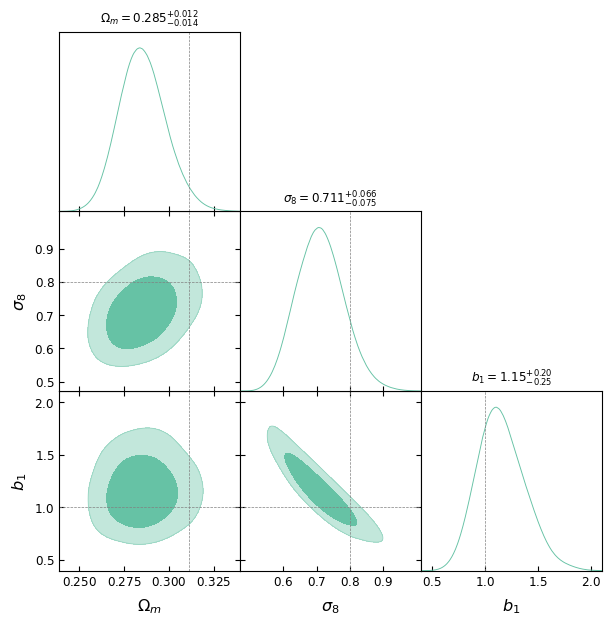

In [ ]:
gdsamp = chains[names[:-1]].to_getdist()

gdplt = plots.get_subplot_plotter(width_inch=7)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,
                contour_colors=[SetDark2(0)],)

Removed no burn in


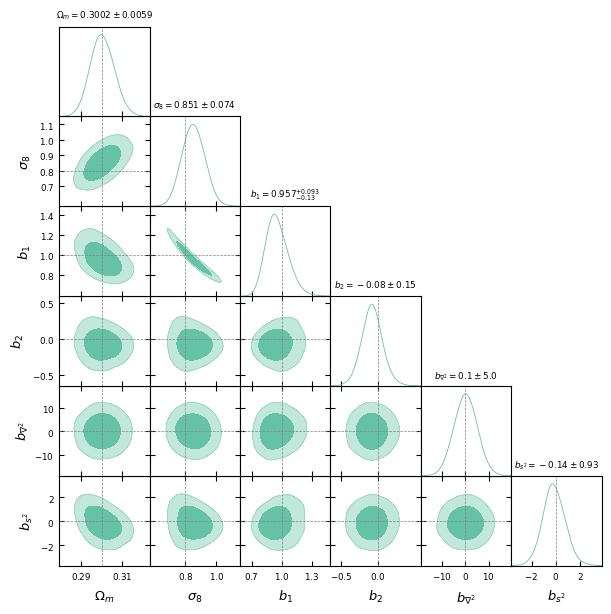

In [ ]:
gdsamp = chains[names[:-1]].to_getdist()

gdplt = plots.get_subplot_plotter(width_inch=7)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,
                contour_colors=[SetDark2(0)],)

Removed no burn in


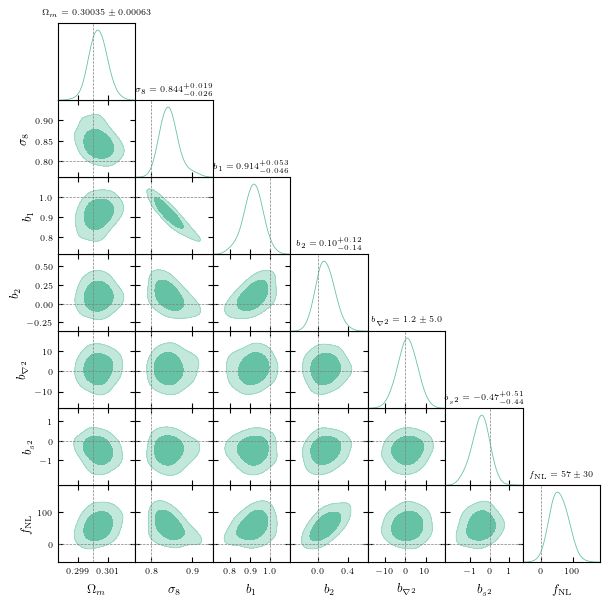

In [ ]:
gdsamp = chains[names[:-1]].to_getdist()

gdplt = plots.get_subplot_plotter(width_inch=7)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,
                contour_colors=[SetDark2(0)],)

Removed no burn in


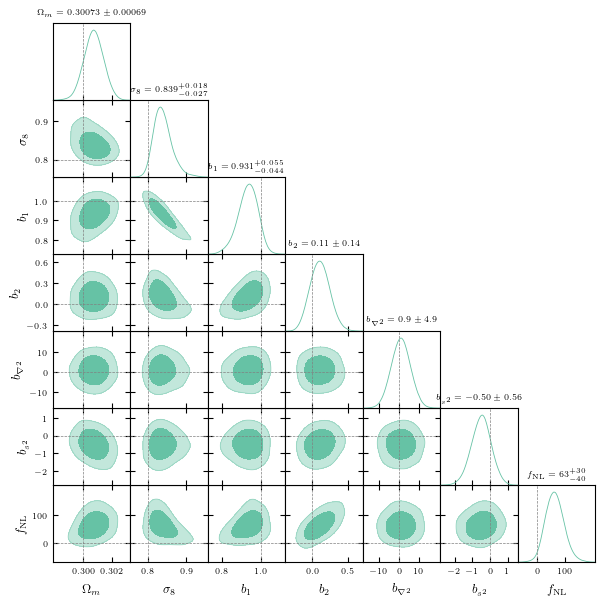

In [ ]:
gdsamp = chains[names[:-1]].to_getdist()

gdplt = plots.get_subplot_plotter(width_inch=7)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,
                contour_colors=[SetDark2(0)],)

Removed no burn in


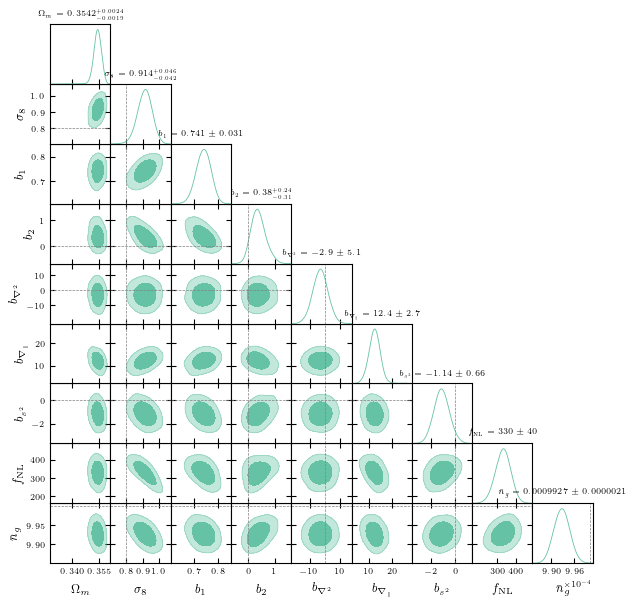

In [ ]:
gdsamp = chains[names[:-1]].to_getdist()

gdplt = plots.get_subplot_plotter(width_inch=7)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,
                contour_colors=[SetDark2(0)],)

Removed no burn in


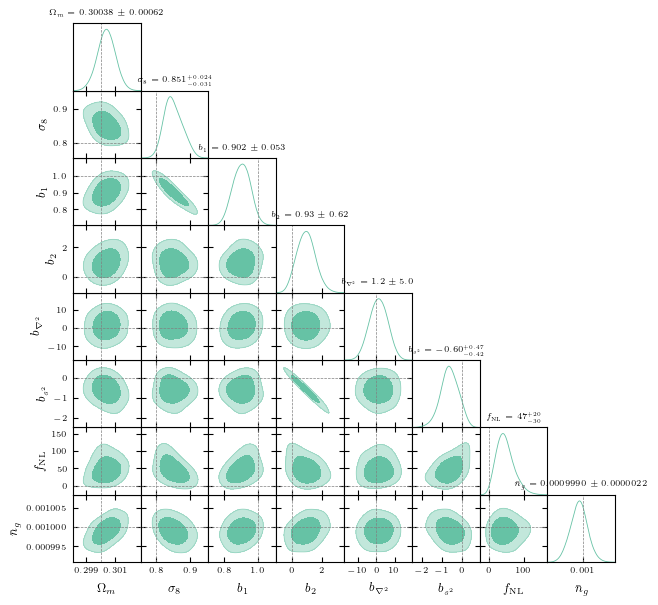

In [ ]:
gdsamp = chains[names[:-1]].to_getdist()

gdplt = plots.get_subplot_plotter(width_inch=7)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,
                contour_colors=[SetDark2(0)],)

Removed no burn in


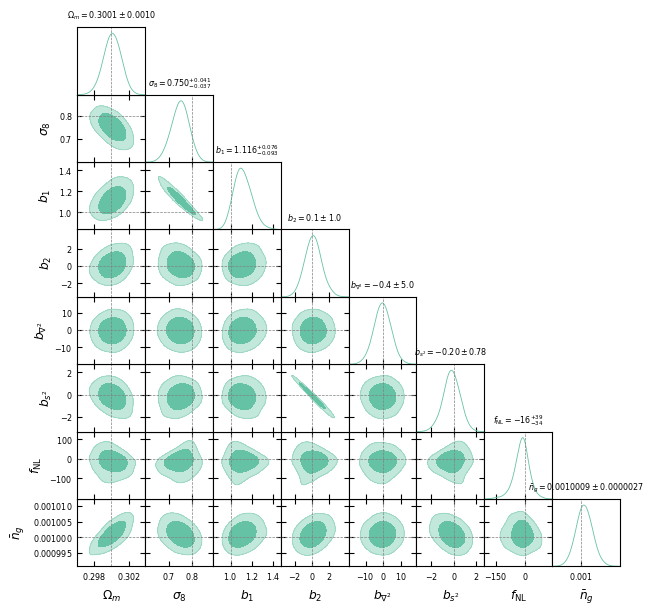

In [ ]:
gdsamp = chains[names[:-1]].to_getdist()

gdplt = plots.get_subplot_plotter(width_inch=7)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,
                contour_colors=[SetDark2(0)],)

Removed no burn in


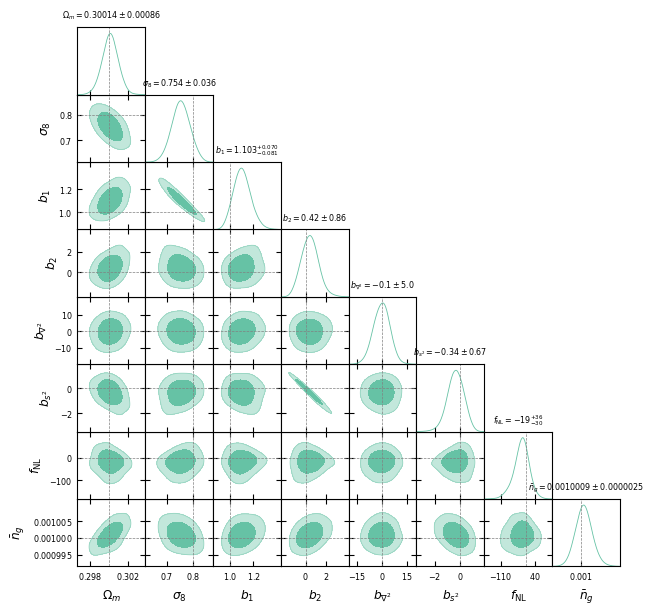

In [ ]:
gdsamp = chains[names[:-1]].to_getdist()

gdplt = plots.get_subplot_plotter(width_inch=7)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,
                contour_colors=[SetDark2(0)],)

Removed no burn in


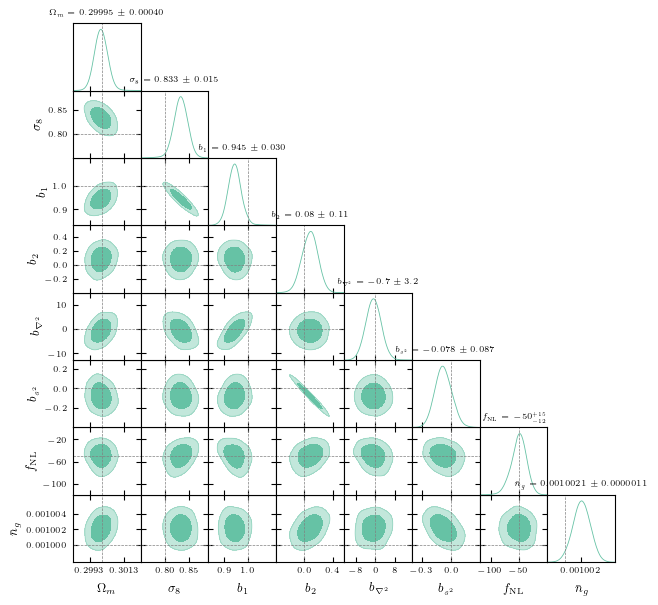

In [ ]:
gdsamp = chains[names[:-1]].to_getdist()

gdplt = plots.get_subplot_plotter(width_inch=7)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,
                contour_colors=[SetDark2(0)],)

### Inspection at the field-Level
Power spectrum should converge close to the truth, and coherence must be on the order of the coherence between truth and obs

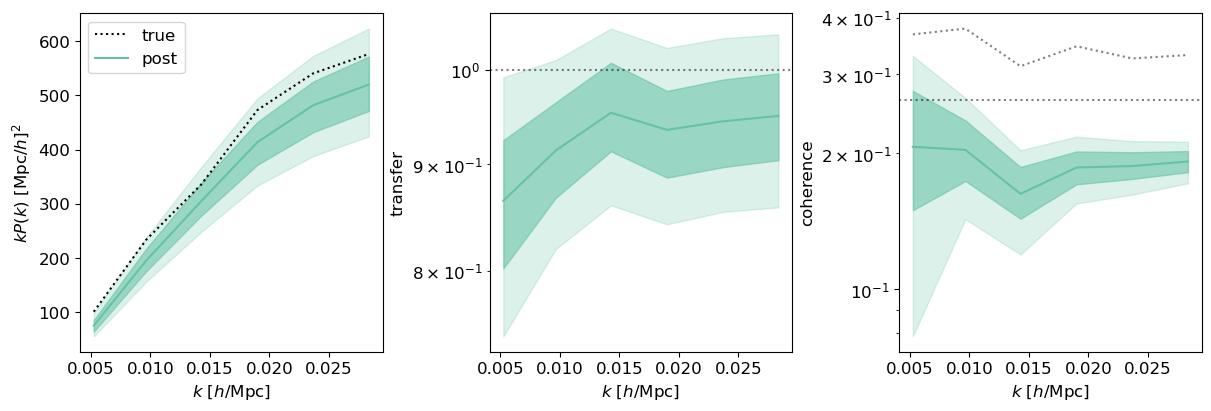

In [15]:
from montecosmo.plot import plot_pow, plot_trans, plot_coh, plot_powtranscoh, theme, SetDark2

prob = 0.95
plt.figure(figsize=(12, 4), layout='constrained')
def plot_kptcs(kptcs, label=None):
    plot_powtranscoh(*kptcs, fill=0.68, color=SetDark2(0))
    plot_powtranscoh(*kptcs, fill=0.95, color=SetDark2(0))
    plot_powtranscoh(*tree.map(lambda x: jnp.median(x, 0), kptcs), label=label)

plt.subplot(131)
plot_pow(*kpow_true, 'k:', label='true')
plt.subplot(132)
plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plt.subplot(133)
plt.axhline(model.wind_mesh.mean(), linestyle=':', color='k', alpha=0.5)
plot_coh(kptc_obs[0], kptc_obs[3], 'k:', alpha=0.5, label='obs')

kptcs = tree.map(jnp.concatenate, chains['kptc'])
plot_kptcs(kptcs, label='post')
plt.subplot(131)
plt.legend();
# plt.savefig(f'init_warm.png')   

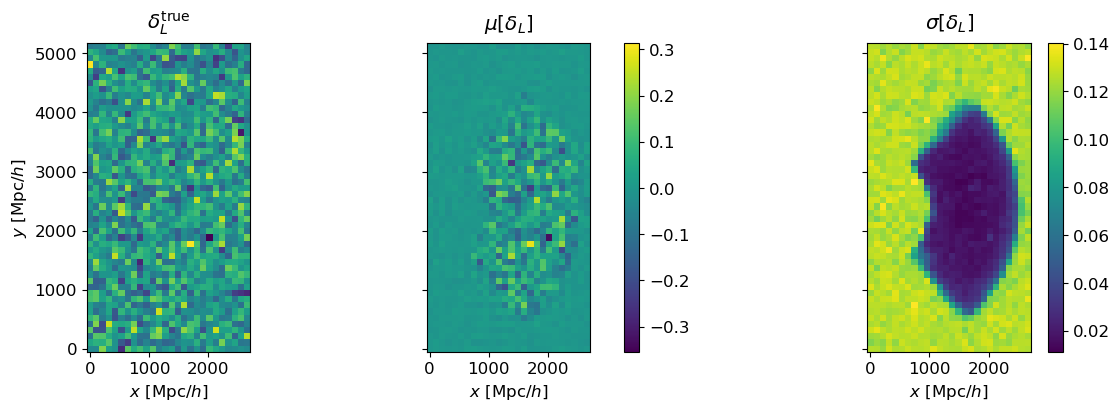

In [16]:
from montecosmo.plot import plot_mesh

axis = 2
ind = .1
meshes = jnp.concatenate(chains_mesh['init'])

plt.figure(figsize=(12, 4), layout='constrained')
ax1 = plt.subplot(131)
plt.title('$\\delta_L^\\mathrm{true}$', pad=10)
quad1 = plot_mesh(mesh_true, model.box_size, ind, axis)
clim = quad1.get_clim()

ax2 = plt.subplot(132, sharey=ax1)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.title('$\\mu[\\delta_L]$', pad=10)
plot_mesh(meshes.mean(0), model.box_size, ind, axis, vlim=clim)
plt.ylabel(None)
plt.colorbar(ax=np.array([ax1, ax2]))

ax3 = plt.subplot(133)
plt.setp(ax3.get_yticklabels(), visible=False)
plt.title('$\\sigma[\\delta_L]$', pad=10)
plot_mesh(meshes.std(0), model.box_size, ind, axis)
plt.ylabel(None)
plt.colorbar();

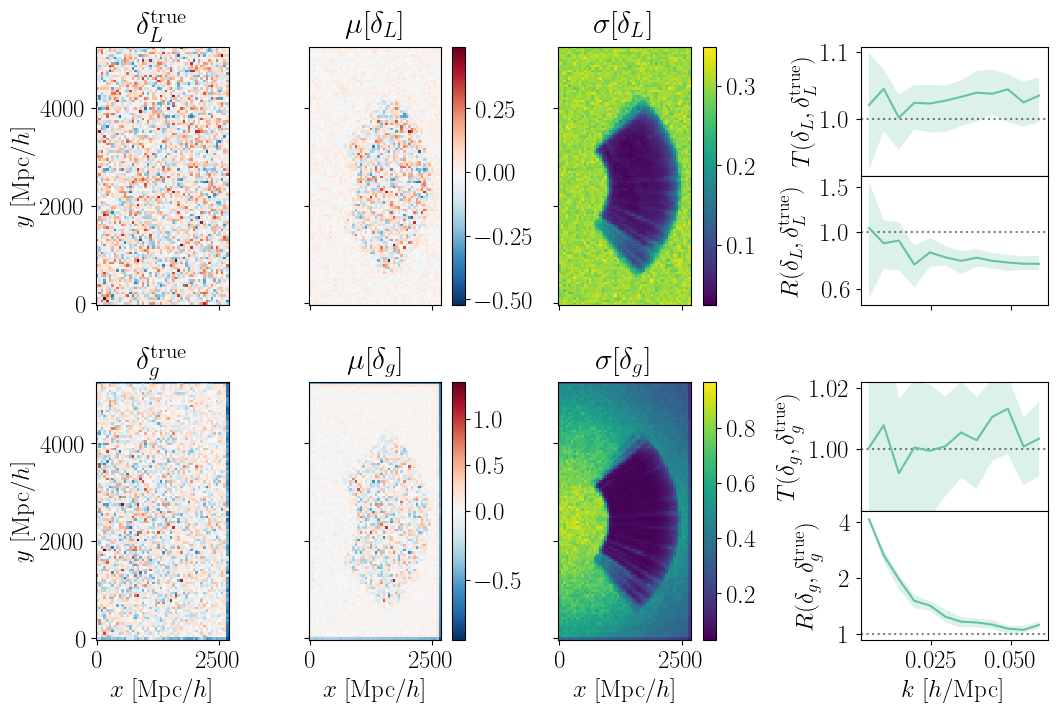

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from montecosmo.plot import plot_pow, plot_trans, plot_coh, plot_powtranscoh, plot_mesh, theme, SetDark2
theme(usetex=True, font_size=18)

chpost = jnp.load("post.npz")
chpopred = jnp.load("postpred.npz")

def scalarformatter(n):
    plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.gca().yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
    if isinstance(n, int):
        plt.gca().yaxis.set_major_locator(mpl.ticker.MaxNLocator(n))
        plt.gca().yaxis.set_minor_locator(mpl.ticker.MaxNLocator(n))
    else:
        plt.gca().yaxis.set_major_locator(mpl.ticker.FixedLocator(n))
        plt.gca().yaxis.set_minor_locator(mpl.ticker.FixedLocator([]))
        

# Create a figure
# fig = plt.figure(figsize=(18, 7.7))
fig = plt.figure(figsize=(14, 7.7))

gs14 = GridSpec(2, 4, figure=fig, wspace=0.6, hspace=0.3)
gs21_14 = gs14[0, 3].subgridspec(2, 1, hspace=0)
gs21_24 = gs14[1, 3].subgridspec(2, 1, hspace=0)

gs12_11 = gs14[0, 0:3].subgridspec(1, 3, wspace=-0.2)
gs12_21 = gs14[1, 0:3].subgridspec(1, 3, wspace=-0.2)

# Add subplots to the inner grid
ax141 = fig.add_subplot(gs21_14[0])
ax142 = fig.add_subplot(gs21_14[1], sharex=ax141)
plt.setp(ax141.get_xticklabels(), visible=False)
plt.setp(ax142.get_xticklabels(), visible=False)


ax241 = fig.add_subplot(gs21_24[0])
ax242 = fig.add_subplot(gs21_24[1], sharex=ax241)
plt.setp(ax241.get_xticklabels(), visible=False)

ax11 = fig.add_subplot(gs12_11[0])
plt.setp(ax11.get_xticklabels(), visible=False)
ax12 = fig.add_subplot(gs12_11[1], sharey=ax11)
plt.setp(ax12.get_yticklabels(), visible=False)
plt.setp(ax12.get_xticklabels(), visible=False)
# ax112.set_yticks([])
ax13 = fig.add_subplot(gs12_11[2], sharey=ax11)
plt.setp(ax13.get_yticklabels(), visible=False)
plt.setp(ax13.get_xticklabels(), visible=False)

ax21 = fig.add_subplot(gs12_21[0])
ax22 = fig.add_subplot(gs12_21[1], sharey=ax21)
plt.setp(ax22.get_yticklabels(), visible=False)
ax23 = fig.add_subplot(gs12_21[2], sharey=ax21)
plt.setp(ax23.get_yticklabels(), visible=False)




# Linear matter field
ids = 0.1
log = False
prob = 0.95
cmap = 'viridis'
cmap2 = 'RdBu_r'
axis = 2
transpose = False
meshes = jnp.concatenate(chpost['init_mesh'])

plt.sca(ax11)
quad11 = plot_mesh(mesh_true, model.box_size, ids, axis, transpose=transpose, cmap=cmap2)
# plt.colorbar()
plt.xlabel(None)
plt.title('$ \\delta_L^\\mathrm{true}$', pad=10)
clim = quad11.get_clim()

plt.sca(ax12)
plot_mesh(meshes.mean(0), model.box_size, ids, axis, vlim=clim, transpose=transpose, cmap=cmap2)
plt.ylabel(None)
# plt.yticks([])
plt.xlabel(None)
plt.title('$\\mu[\\delta_L]$', pad=10)
plt.colorbar(ax=np.array([ax11, ax12]), pad=0.02, fraction=0.1)

plt.sca(ax13)
plot_mesh(meshes.std(0), model.box_size, ids, axis, transpose=transpose, cmap=cmap)
plt.ylabel(None)
plt.xlabel(None)
plt.colorbar(pad=0.04)
plt.title('$\\sigma[\\delta_L]$', pad=10)

plt.sca(ax141)
kptcs = tree.map(jnp.concatenate, tuple(chpost['kptc']))
kptc_med = tree.map(lambda x: jnp.median(x, 0), kptcs)

plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plot_trans(kptc_med[0], kptc_med[2])
plot_trans(kptcs[0], kptcs[2], fill=prob)
plt.ylabel('$T(\\delta_L, \\delta_L^\\mathrm{true})$')
plt.xlabel(None)
scalarformatter(2)

plt.sca(ax142)
plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plot_coh(kptc_med[0], kptc_med[3])
plot_coh(kptcs[0], kptcs[3], fill=prob)
plt.ylabel('$R(\\delta_L, \\delta_L^\\mathrm{true})$', labelpad=12)
# scalarformatter([1.0, 0.5, 0.1])
scalarformatter([1.5, 1.0, 0.6])
plt.xlabel(None)


# Galaxy density field
ids = 0.1
log = False
prob = 0.95
# meshes = jnp.concatenate(model.count2delta(chpopred['obs']))
meshes = jnp.concatenate(chpopred['gxy_mesh'])-1

lim = 5
# vmin = 0.4
# means = jnp.maximum(meshes, vmin).mean(0)
means = meshes.mean(0)
vmax = np.quantile(means, 1-1e-4/2)

plt.sca(ax21)
quad21 = plot_mesh(truth['gxy_mesh']-1, model.box_size, ids, axis, vlim=None, transpose=transpose, cmap=cmap2)
clim = quad21.get_clim()
norm = colors.TwoSlopeNorm(0., *clim)
quad21 = plot_mesh(truth['gxy_mesh']-1, model.box_size, ids, axis, vlim=None, transpose=transpose, cmap=cmap2, norm=norm)
# quad21 = plot_mesh(jnp.maximum(delta_obs, vmin), model.box_size, ids, axis, vlim=(vmin,vmax), transpose=True, cmap=cmap)
plt.title('$\\delta_g^\\mathrm{true}$', pad=10)

plt.sca(ax22)
plot_mesh(means, model.box_size, ids, axis, vlim=None, transpose=transpose, cmap=cmap2, norm=norm)
plt.ylabel(None)
# plt.yticks([])
plt.title('$\\mu[\\delta_g]$', pad=10)
from matplotlib import colors
plt.colorbar(ax=np.array([ax21, ax22]), pad=0.02, fraction=0.1)

plt.sca(ax23)
plot_mesh(meshes.std(0), model.box_size, ids, axis, transpose=transpose, cmap=cmap)
plt.ylabel(None)
plt.colorbar(pad=0.04)
plt.title('$\\sigma[\\delta_g]$', pad=10)

plt.sca(ax241)
kptcs = tree.map(jnp.concatenate, tuple(chpopred['kptc']))
kptc_med = tree.map(lambda x: jnp.median(x, 0), kptcs)

plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plot_trans(kptc_med[0], kptc_med[2])
plot_trans(kptcs[0], kptcs[2], fill=prob)
plt.ylabel('$T(\\delta_g, \\delta_g^\\mathrm{true})$')
plt.xlabel(None)
plt.ylim(0.98, 1.022)
scalarformatter([1.0, 1.02])

plt.sca(ax242)
plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plot_coh(kptc_med[0], kptc_med[3])
plot_coh(kptcs[0], kptcs[3], fill=prob)
plt.ylabel('$R(\\delta_g, \\delta_g^\\mathrm{true})$', labelpad=12)
# ax242.yaxis.set_label_position("right")
# ax242.set_ylabel('$R(\\delta_g, \\delta_g^\\mathrm{true})$', rotation=270, labelpad=20)
# scalarformatter([1.0, 0.8, 0.4])
scalarformatter([4., 2., 1.])

plt.savefig('postfields_fnl_p50.png', dpi=500, bbox_inches='tight')
plt.show()

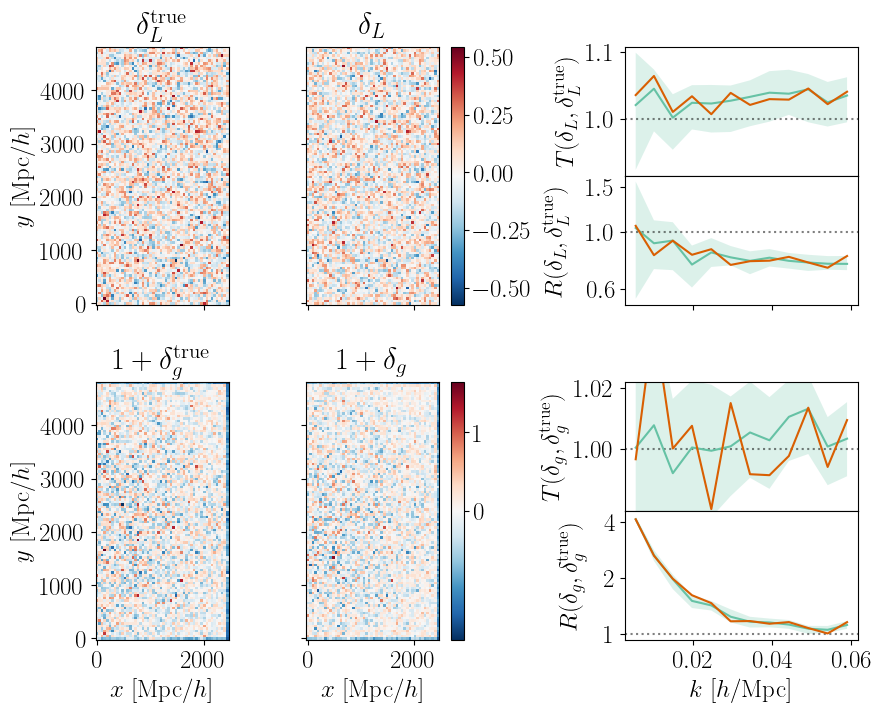

In [151]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib.animation import FuncAnimation
from montecosmo.plot import plot_mesh, mean_proj
theme(dark=False, usetex=True, font_size=18, cmap="SetDark2")

chpost = jnp.load("post.npz")
chpopred = jnp.load("postpred.npz")

def scalarformatter(n):
    plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.gca().yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
    if isinstance(n, int):
        plt.gca().yaxis.set_major_locator(mpl.ticker.MaxNLocator(n))
        plt.gca().yaxis.set_minor_locator(mpl.ticker.MaxNLocator(n))
    else:
        plt.gca().yaxis.set_major_locator(mpl.ticker.FixedLocator(n))
        plt.gca().yaxis.set_minor_locator(mpl.ticker.FixedLocator([]))
        
 
# Create a figure
i_plt = 0
fig = plt.figure(figsize=(12, 7.7))

gs23 = GridSpec(2, 3, figure=fig, wspace=0.5, hspace=0.3)
gs21_13 = gs23[0, 2].subgridspec(2, 1, hspace=0)
gs21_23 = gs23[1, 2].subgridspec(2, 1, hspace=0)

gs12_11 = gs23[0, 0:2].subgridspec(1, 2, wspace=-0.3)
gs12_21 = gs23[1, 0:2].subgridspec(1, 2, wspace=-0.3)

# Add subplots to the inner grid
ax131 = fig.add_subplot(gs21_13[0])
ax132 = fig.add_subplot(gs21_13[1], sharex=ax131)
plt.setp(ax131.get_xticklabels(), visible=False)
plt.setp(ax132.get_xticklabels(), visible=False)

ax231 = fig.add_subplot(gs21_23[0])
ax232 = fig.add_subplot(gs21_23[1], sharex=ax231)
plt.setp(ax231.get_xticklabels(), visible=False)


ax11 = fig.add_subplot(gs12_11[0])
plt.setp(ax11.get_xticklabels(), visible=False)
ax12 = fig.add_subplot(gs12_11[1], sharey=ax11)
plt.setp(ax12.get_yticklabels(), visible=False)
plt.setp(ax12.get_xticklabels(), visible=False)
# ax112.set_yticks([])

ax21 = fig.add_subplot(gs12_21[0])
ax22 = fig.add_subplot(gs12_21[1], sharey=ax21)
plt.setp(ax22.get_yticklabels(), visible=False)




# Linear matter field
ids = 0.1
log = False
prob = 0.95
cmap = 'viridis'
cmap2 = 'RdBu_r'
axis = -1
transpose = False
meshes1 = jnp.concatenate(chpost['init_mesh'])
alpha = (1-prob)**.5
# alpha = 0.5



plt.sca(ax11)
quad11 = plot_mesh(mesh_true, model.box_size, ids, axis, transpose=transpose, cmap=cmap2)
# plt.colorbar()
plt.xlabel(None)
plt.title('$ \\delta_L^\\mathrm{true}$', pad=10)
clim = quad11.get_clim()

plt.sca(ax12)
means = meshes1[i_plt]
quad12 = plot_mesh(means, model.box_size, ids, axis, vlim=clim, transpose=transpose, cmap=cmap2)
plt.ylabel(None)
# plt.yticks([])
plt.xlabel(None)
plt.title('$\\delta_L$', pad=10)
plt.colorbar(ax=np.array([ax11, ax12]), pad=0.02, fraction=0.1)


plt.sca(ax131)
kptcs1 = tree.map(jnp.concatenate, tuple(chpost['kptc']))
kptc_med1 = tree.map(lambda x: jnp.median(x, 0), kptcs1)

plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plot_trans(kptc_med1[0], kptc_med1[2])
plot_trans(kptcs1[0], kptcs1[2], fill=prob, alpha=alpha)
line131, = plot_trans(kptcs1[0][i_plt], kptcs1[2][i_plt])
plt.ylabel('$T(\\delta_L, \\delta_L^\\mathrm{true})$')
plt.xlabel(None)
scalarformatter(2)

plt.sca(ax132)
plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plot_coh(kptc_med1[0], kptc_med1[3])
plot_coh(kptcs1[0], kptcs1[3], fill=prob, alpha=alpha)
line132, = plot_trans(kptcs1[0][i_plt], kptcs1[3][i_plt])
plt.ylabel('$R(\\delta_L, \\delta_L^\\mathrm{true})$', labelpad=12)
# scalarformatter([1.0, 0.5, 0.1])
scalarformatter([1.5, 1.0, 0.6])
plt.xlabel(None)


# Galaxy density field
sli = 1
log = False
prob = 0.95
# meshes2 = jnp.concatenate(model.count2delta(chpopred['obs']))
meshes2 = jnp.concatenate(chpopred['gxy_mesh'])-1

# vmin = 0.3
# meshes2 = jnp.maximum(meshes2, vmin)
# means = meshes2[...,None]
# vmax = np.quantile(means, [1-1e-4/2])
means = meshes2[i_plt]

plt.sca(ax21)
quad21 = plot_mesh(truth['gxy_mesh']-1, model.box_size, ids, axis, vlim=None, transpose=transpose, cmap=cmap2)
clim = quad21.get_clim()
norm = colors.TwoSlopeNorm(0., *clim)
quad21 = plot_mesh(truth['gxy_mesh']-1, model.box_size, ids, axis, vlim=None, transpose=transpose, cmap=cmap2, norm=norm)
# plt.colorbar()
plt.title('$1+ \\delta_g^\\mathrm{true}$', pad=10)

plt.sca(ax22)
quad22 = plot_mesh(means, model.box_size, ids, axis, vlim=None, transpose=transpose, cmap=cmap2, norm=norm)
plt.ylabel(None)
# plt.yticks([])
plt.title('$1+\\delta_g$', pad=10)
plt.colorbar(ax=np.array([ax21, ax22]), pad=0.02, fraction=0.1)

plt.sca(ax231)
kptcs2 = tree.map(jnp.concatenate, tuple(chpopred['kptc']))
kptc_med2 = tree.map(lambda x: jnp.median(x, 0), kptcs2)

plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plot_trans(kptc_med2[0], kptc_med2[2])
plot_trans(kptcs2[0], kptcs2[2], fill=prob, alpha=alpha)
line231, = plot_trans(kptcs2[0][i_plt], kptcs2[2][i_plt])
plt.ylabel('$T(\\delta_g, \\delta_g^\\mathrm{true})$')
plt.xlabel(None)
plt.ylim(0.98, 1.022)
scalarformatter([1.0, 1.02])

plt.sca(ax232)
plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plot_coh(kptc_med2[0], kptc_med2[3])
plot_coh(kptcs2[0], kptcs2[3], fill=prob, alpha=alpha)
line232, = plot_trans(kptcs2[0][i_plt], kptcs2[3][i_plt])
plt.ylabel('$R(\\delta_g, \\delta_g^\\mathrm{true})$', labelpad=12)
# ax242.yaxis.set_label_position("right")
# ax242.set_ylabel('$R(\\delta_g, \\delta_g^\\mathrm{true})$', rotation=270, labelpad=20)
scalarformatter([4., 2., 1.])

# plt.savefig('post_fields4.png', dpi=500, bbox_inches='tight')
# plt.show()


thinning = 1
def update(i):
    quad12.set_array(mean_proj(meshes1, ids, axis)[::thinning][i])
    quad22.set_array(mean_proj(meshes2, ids, axis)[::thinning][i])

    kptc = tree.map(lambda x: x[::2*thinning][i], kptcs1)
    ks, pow, trans, coh = kptc
    line131.set_data(ks, trans)
    line132.set_data(ks, coh)

    kptc = tree.map(lambda x: x[::thinning][i], kptcs2)
    ks, pow, trans, coh = kptc
    line231.set_data(ks, trans)
    line232.set_data(ks, coh)
  
    return quad12, quad22, line131, line132, line231, line232


display(plt.gcf())
anim = FuncAnimation(plt.gcf(), update, frames=30, interval=100, blit=True)
# anim.save("chains.mp4", dpi=300)
# anim.save("chains.gif", dpi=300)
display(anim)
plt.close()

In [87]:
from montecosmo.bricks import add_png, get_cosmology 
# init['init_mesh'] = vmap(lambda x: add_png(get_cosmology(**truth), truth['fNL'], x, model.mesh_shape, model.box_size))()
init_nl = (lambda x: jnp.fft.irfftn(add_png(get_cosmology(**truth), truth['fNL'], x, model.mesh_shape, model.box_size)))(truth['init_mesh'])

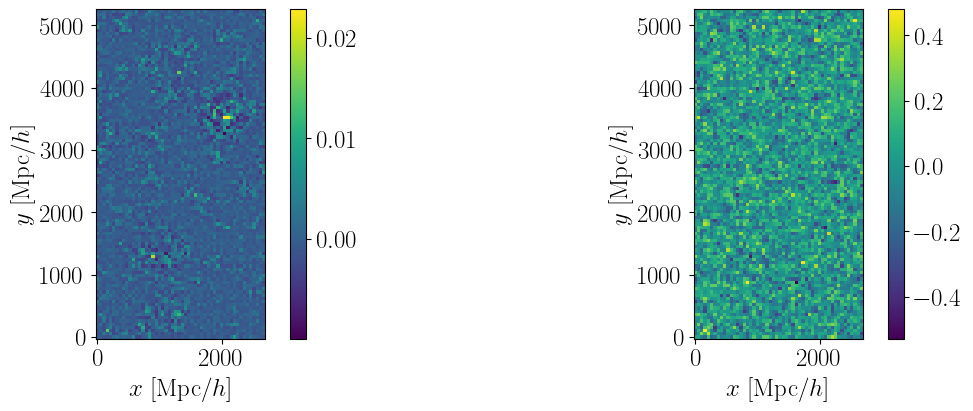

In [104]:
plt.figure(figsize=(12, 4), layout='constrained')
plt.subplot(121)
plot_mesh(mesh_true-init_nl, model.box_size, 0.1, 2)
plt.colorbar()
plt.subplot(122)
plot_mesh(init_nl, model.box_size, 0.1, 2)
plt.colorbar()

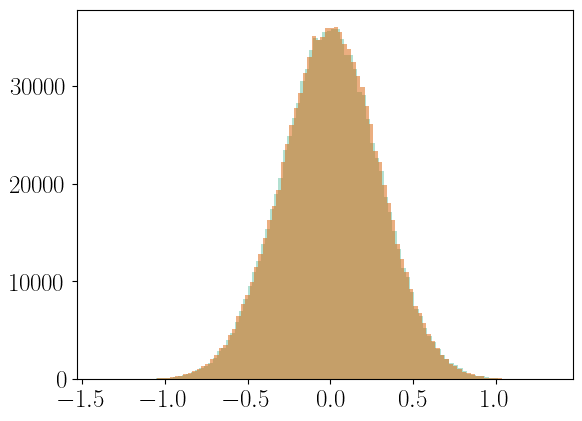

In [103]:
plt.hist(np.random.choice(mesh_true.flatten(), 1000_000), bins=100, alpha=0.5, label='true');
plt.hist(np.random.choice(init_nl.flatten(), 1000_000), bins=100, alpha=0.5, label='true');

## Example 2: quantify MCMC performance

### Number of eval per effective sample should converge. If so, that's a relevant metric.

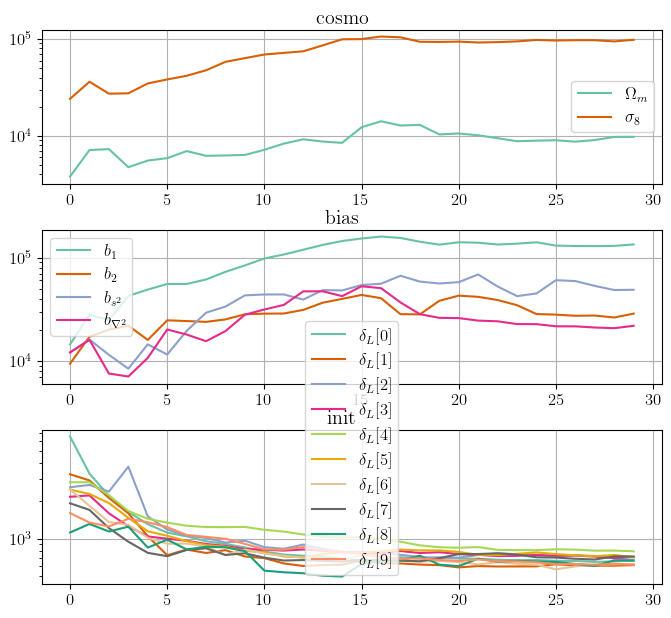

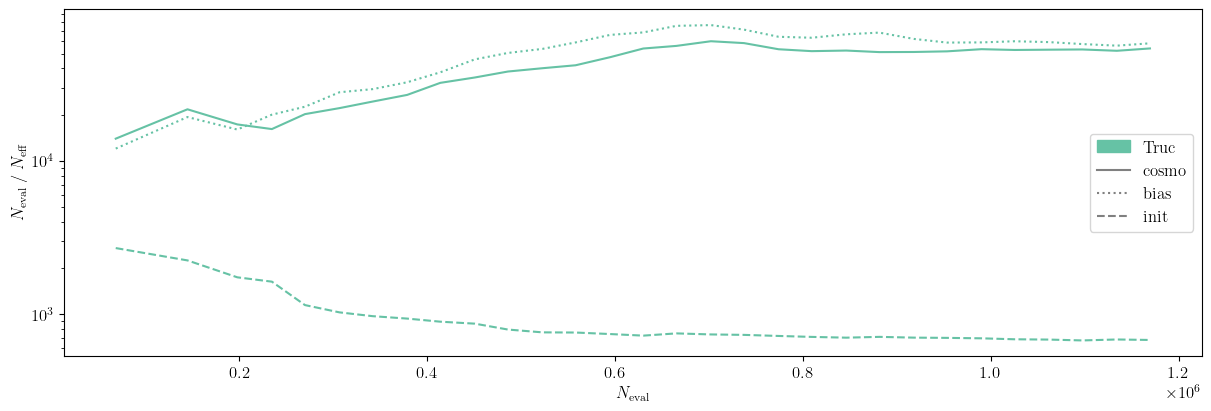

In [ ]:
plt.figure(figsize=(8, 6))
chains[['*~kptc']].flatten().cumtrans(Chains.eval_per_ess, 30).plot(names, 1, log=True)

labels = ['Truc']
metrics = []
cumess = chains[['*~kptc']].stackby(names).cumtrans(Chains.eval_per_ess, 30)
metrics.append(cumess)

def plot_fn(metrics, labels):
    plt.figure(figsize=(12, 4), layout="constrained")
    i_start = 0
    styles = ['-', ':', '--']
    for i_m, (metric, meth) in enumerate(zip(metrics, labels)):
        for i_g, (st, g) in enumerate(zip(styles, names)):
            plt.semilogy(metric['n_evals'][i_start:], metric[g][i_start:], st, c=SetDark2(i_m), label=g)

    from matplotlib.lines import Line2D; from matplotlib.patches import Patch
    handles = []
    for i_m, method in enumerate(labels):
        handles.append(Patch(color=SetDark2(i_m), label=method))
    for i_g, g in enumerate(names):
        handles.append(Line2D([], [], color='grey', linestyle=styles[i_g], label=g))

    plt.legend(handles=handles);

plot_fn(metrics, labels)
plt.xlabel("$N_{\\mathrm{eval}}$")
plt.ylabel("$N_{\\mathrm{eval}}\\;/\\;N_{\\mathrm{eff}}$");

## Comparison

norsd
Loading: test, from run 2 to run 15 (included)
File /feynman/home/dphp/hs276503/scratch/png/kaiser_test3/test_7.npz does not exist, stopping at run 6
norsd
{'Omega_m': (6, 640), 'b1': (6, 640), 'init_mesh': (6, 640, 10), 'kptc': ((6, 640, 6), (6, 640, 6), (6, 640, 6), (6, 640, 6)), 'logdensity': (6, 640), 'mse_per_dim': (6, 640), 'n_evals': (6, 640), 'ngbar': (6, 640), 'sigma8': (6, 640)}

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
      Omega_m      0.28      0.01      0.28      0.26      0.30   2056.51      1.00
       sigma8      0.72      0.07      0.72      0.59      0.83   1094.40      1.00
 init_mesh[0]     -0.00      0.00     -0.00     -0.01      0.01   3052.95      1.00
 init_mesh[1]     -0.00      0.00     -0.00     -0.01      0.01   3056.81      1.00
 init_mesh[2]      0.00      0.00      0.00     -0.01      0.01   3010.18      1.00
 init_mesh[3]      0.00      0.00      0.00     -0.01      0.01   3086.18      1.00
 init_mesh[4]

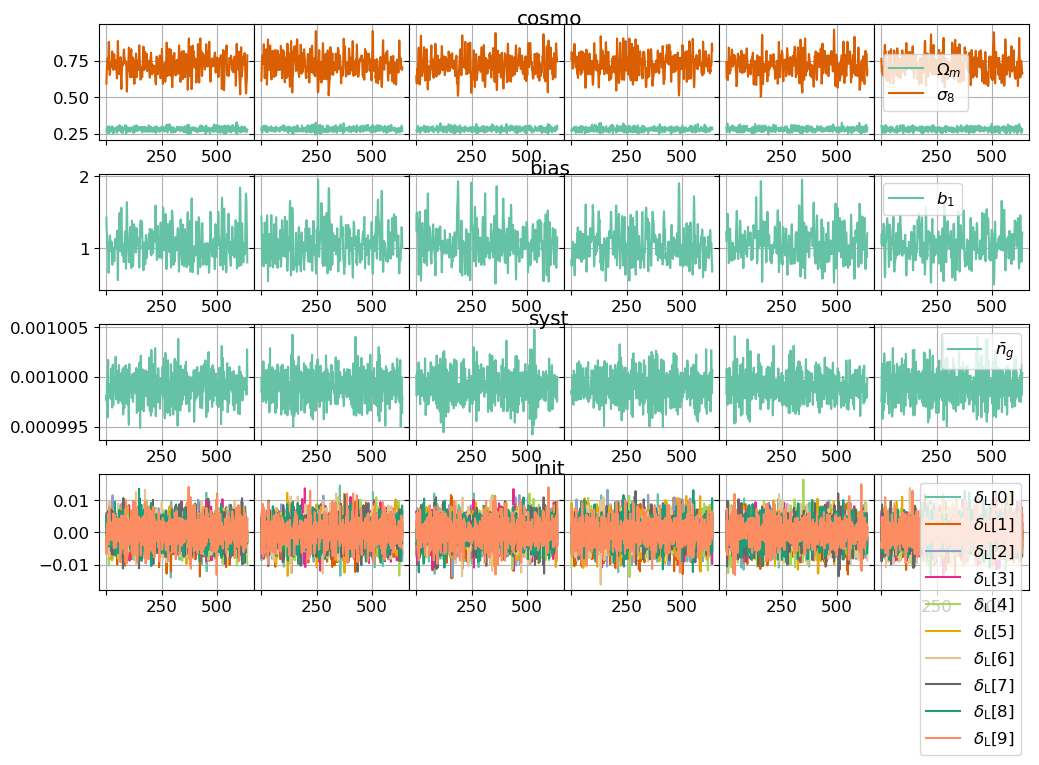

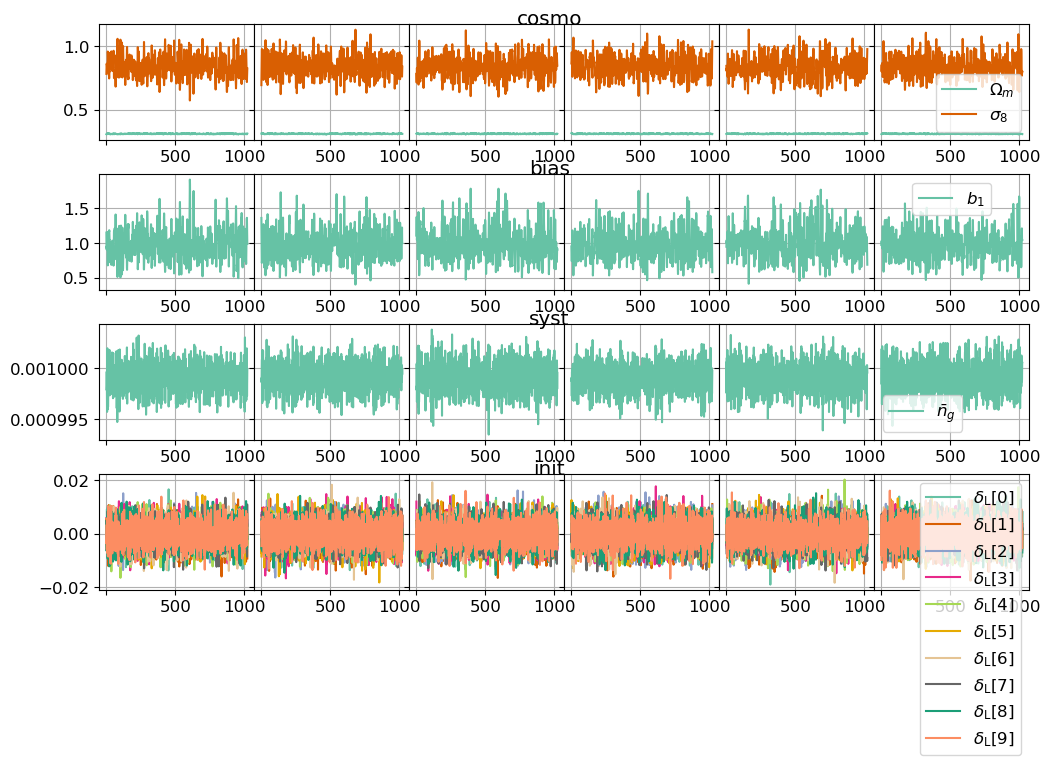

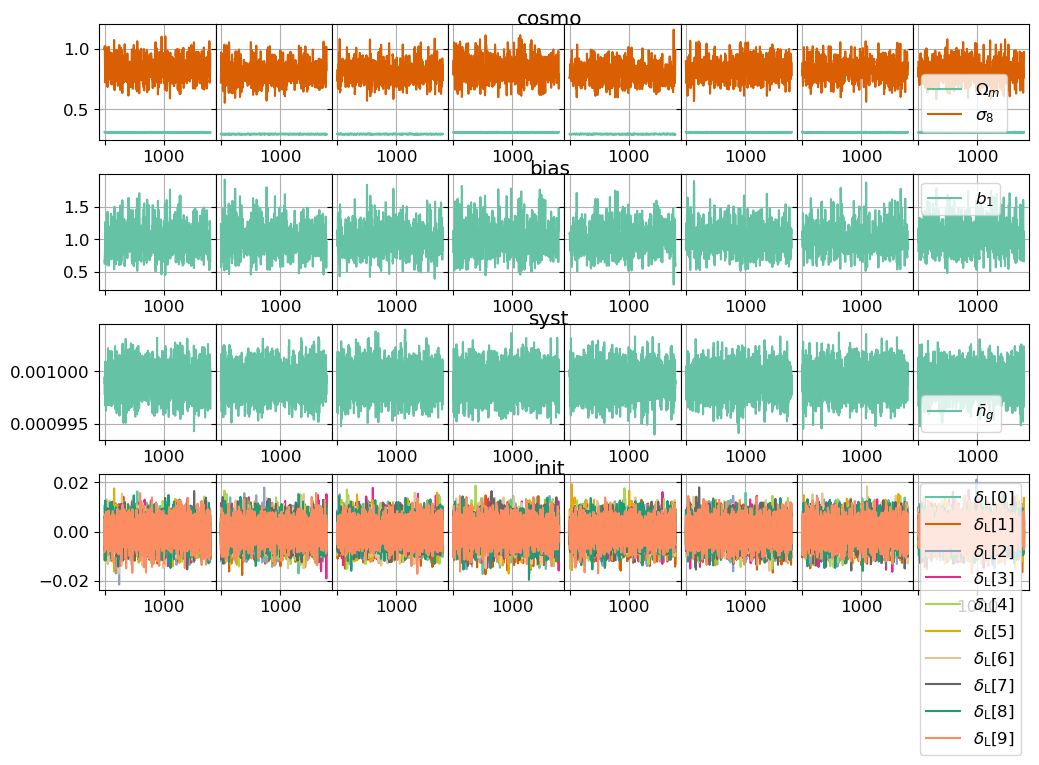

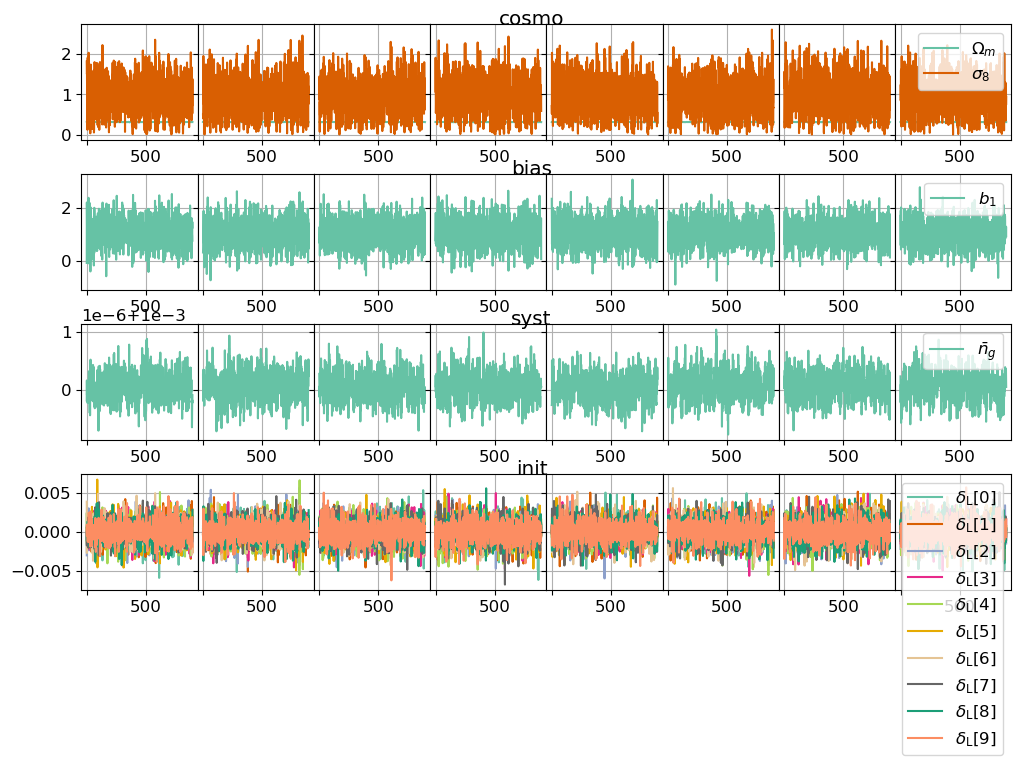

In [8]:
from montecosmo.chains import Chains
from montecosmo.plot import plot_pow, plot_trans, plot_coh, plot_powtranscoh, theme, SetDark2
theme(usetex=False, font_size=12)

ids = np.array([0,1,2,3])
save_dir = Path("/feynman/home/dphp/hs276503/scratch/png")
# save_dir = Path("/pscratch/sd/h/hsimfroy/png")
save_dirs = np.array([save_dir / s for s in [
    "kaiser_test3",
    "kaiser_test4",
    "kaiser_test5",
    "kaiser_test6",

    "lpt_32_fnl_0_lc_apauto", 
    "lpt_32_fnl_0_lc_apauto_flat", 
    "lpt_32_fnl_0_lc_apauto_nodec", 

    "lpt_32_fnl_0_lc_apauto", 
    "lpt_64_fnl_0_lc_appar",

    "lpt_64_fnl_p50", 
    "lpt_64_fnl_0", 
    "lpt_64_fnl_m50", 
    "lpt_fnl_64_kaiser_stat"
    ]])[ids]
save_paths = np.array([save_dir / "test" for save_dir in save_dirs])
labels = np.array([
    'noAP, Omfid=0.3111', 
    'AP, Omfid=0.3111', 
    'AP, Omfid=0.305', 
    'AP, Omfid=0.3111', 

    '$f_\\mathrm{NL} = -50$', 
    '$f_\\mathrm{NL} = 0$', 
    '$f_\\mathrm{NL} = +50$', 
    '$f_\\mathrm{NL} = 0, noLC, noAP$'
    ])[ids]

gdsamps = []
kptcs = []
names = ['cosmo','bias','syst','init']
# names = ['cosmo_','bias_','syst_','init_']

for sd, sp, lab in zip(save_dirs, save_paths, labels):
    model = FieldLevelModel.load(sd / "model.yaml")

    truth = dict(jnp.load(sd / 'truth.npz'))
    mesh_true = jnp.fft.irfftn(truth['init_mesh'])
    kpow_true = model.spectrum(mesh_true)
    # delta_obs = model.count2delta(truth['obs'])
    delta_obs = model.count2delta(truth['obs'], from_masked=False)
    kptc_obs = model.powtranscoh(mesh_true, delta_obs)

    obs = ['obs','Omega_m','sigma8','b1','b2','bs2','bn2','fNL','ngbar','init_mesh']
    obs = {k: truth[k] for k in obs}
    model.condition(obs, from_base=True)

    transforms = [
                #   lambda x: x[:3],
                partial(Chains.thin, thinning=1),                     # thin the chains
                model.reparam_chains,                                 # reparametrize sample variables into base variables
                partial(model.powtranscoh_chains, mesh0=mesh_true),   # compute mesh statistics
                partial(Chains.choice, n=10, names=['init','init_']), # subsample mesh 
                Chains.prune, 
                ]
    chains = model.load_runs(sp, 2, 15, transforms=transforms, batch_ndim=2)

    # print("Loading from", sp)
    # chains = pload(sp + "_chains.p")
    # chains = chains[:,100:]

    print(chains.shape)
    plt.figure(figsize=(12,6))
    # chains[['*~kptc']].flatten().plot("Omega_m")
    chains[['*~kptc']].flatten().plot(names)
    chains[['*~kptc']].print_summary()

    gdsamp = chains[names[:-1]].to_getdist(lab)
    gdsamps.append(gdsamp)

    kptc = tree.map(jnp.concatenate, chains.pop('kptc', None))
    kptcs.append(kptc)


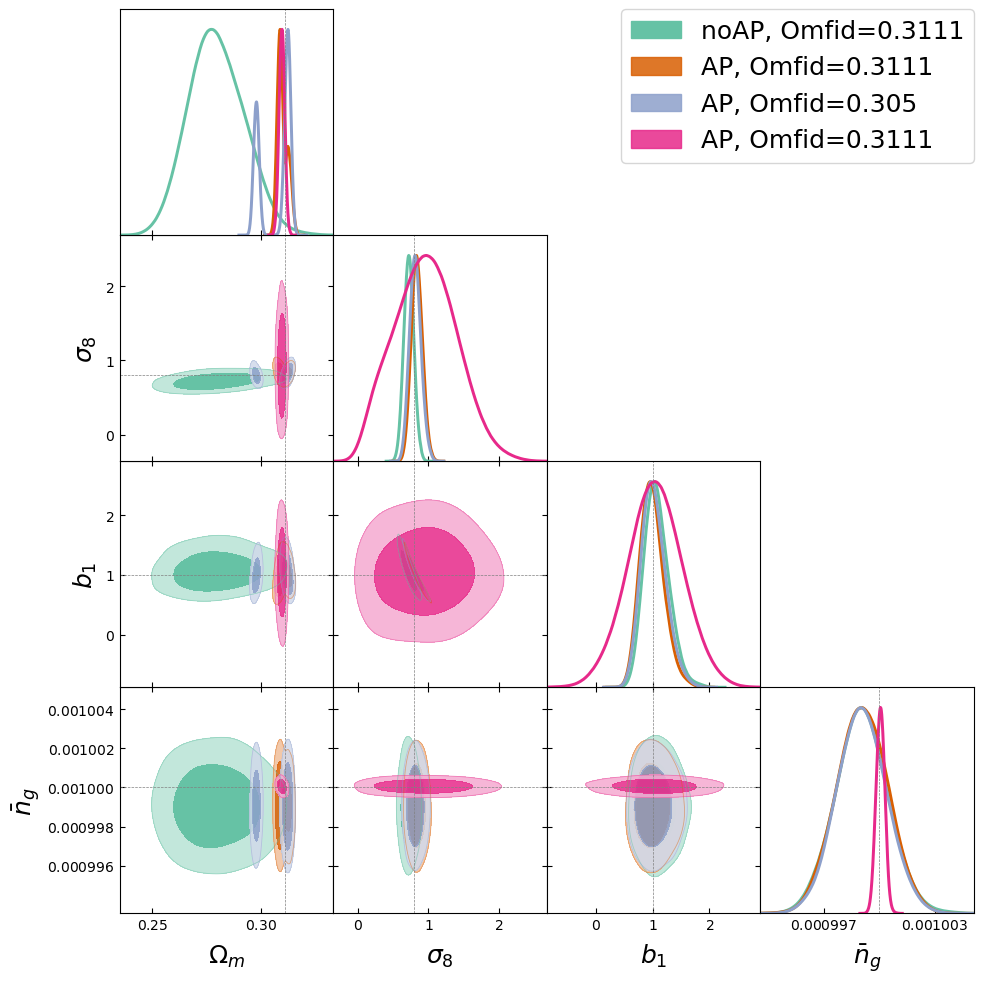

In [9]:
gdplt = plots.get_subplot_plotter(width_inch=10)
gdplt.settings.legend_fontsize = 20
gdplt.settings.axes_labelsize = 20
gdplt.settings.axes_fontsize = 12
gdplt.settings.figure_legend_frame = True
gdplt.settings.linewidth = 3
# gdplt.settings.num_plot_contours = 3
gdplt.triangle_plot(roots=gdsamps[:],
                    # params=['Omega_m','sigma8','b1','fNL'],
                    # params=['Omega_m','sigma8','b1','b2','bs2','bn2','fNL'],
                    # params=['fNL','sigma8','b1','b2','bs2','bn2'],
                # title_limit=1,
                filled=True, 
                # markers={k:v for k,v in truth.items() if k not in ['fNL']},
                markers=truth,
                contour_colors=[SetDark2(i) for i in range(len(gdsamps))],
                legend_loc='upper right',
                )
# plt.savefig(save_dir / 'lpt_64_fnl_triangle.pdf', bbox_inches='tight')
# plt.savefig(save_dir / 'lpt_64_fnl_triangle.png', bbox_inches='tight')
plt.savefig('kaiser_32_Omega2.png', bbox_inches='tight')

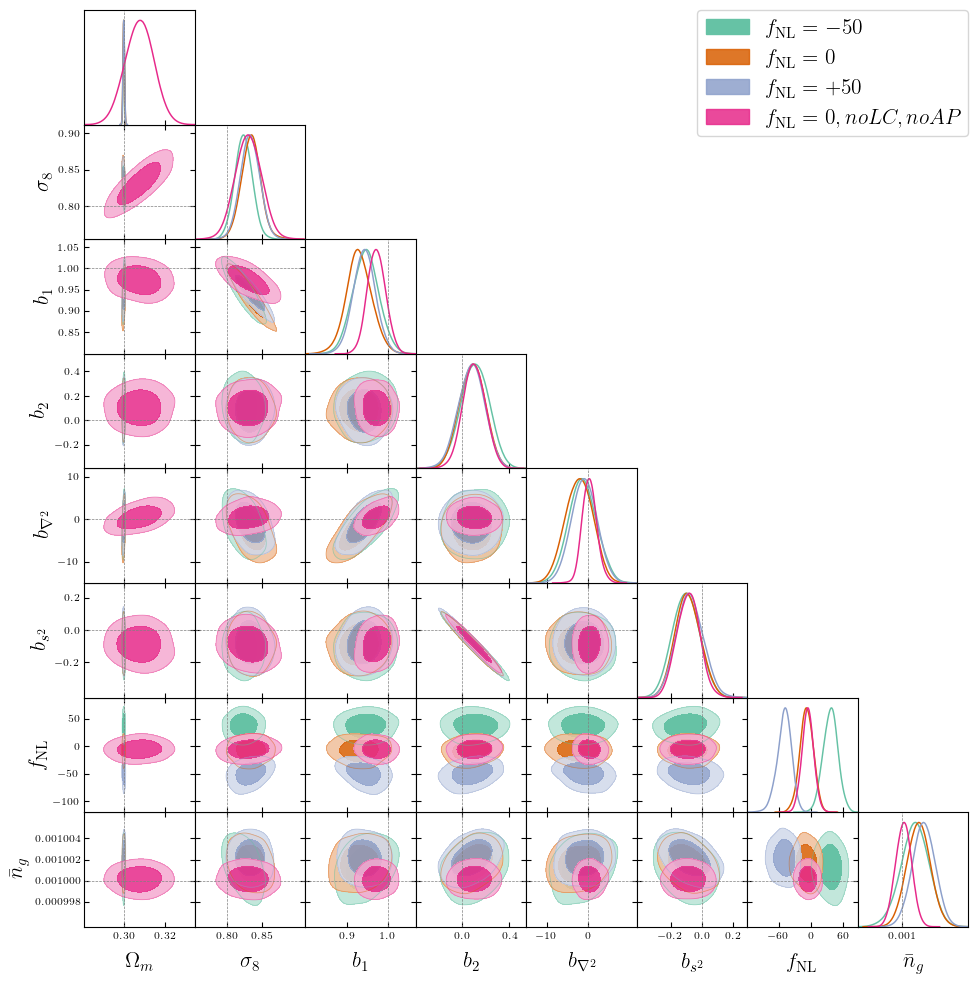

In [ ]:
gdplt = plots.get_subplot_plotter(width_inch=10)
gdplt.settings.legend_fontsize = 20
gdplt.settings.axes_labelsize = 20
gdplt.settings.axes_fontsize = 12
gdplt.settings.figure_legend_frame = True
gdplt.settings.linewidth = 3
# gdplt.settings.num_plot_contours = 3
gdplt.triangle_plot(roots=gdsamps[:],
                    # params=['Omega_m','sigma8','b1','fNL'],
                    # params=['Omega_m','sigma8','b1','b2','bs2','bn2','fNL'],
                    # params=['fNL','sigma8','b1','b2','bs2','bn2'],
                # title_limit=1,
                filled=True, 
                markers={k:v for k,v in truth.items() if k not in ['fNL']},
                contour_colors=[SetDark2(i) for i in range(len(gdsamps))],
                legend_loc='upper right',
                )
# plt.savefig(save_dir / 'lpt_64_fnl_triangle.pdf', bbox_inches='tight')
# plt.savefig(save_dir / 'lpt_64_fnl_triangle.png', bbox_inches='tight')
plt.savefig('lpt_64_fnl_triangle_Omega.png', bbox_inches='tight')